## Imports

In [1]:
import IPython.display as ipd
from scipy.signal import hilbert
import numpy as np
import pandas as pd
import scipy
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import tools

# change style
plt.style.use('ggplot')
import librosa
import librosa.display
from tqdm import tqdm

tqdm.pandas()
import os
from glob import glob
import random
from typing import List, Tuple, Dict

from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

In [2]:
from params import SOUNDS_DATASET_PATH, SAMPLE_RATE, CLASS_COLORS
from tools import play_audio, load_audio_file, pad_signal

## Notes

> L'utilisation du logarithme dans un problème de classification audio a plusieurs avantages :

- Perception auditive : L'échelle de perception de l'intensité sonore par l'oreille humaine est logarithmique. Cela signifie que notre perception de l'intensité sonore augmente de manière non linéaire par rapport à l'énergie du son. En utilisant le logarithme du RMS, nous transformons les valeurs d'énergie en une échelle qui reflète mieux notre perception du volume sonore.

- Normalisation : Les valeurs de RMS peuvent varier considérablement en fonction de l'amplitude du signal audio. En utilisant le logarithme, nous réduisons cette variation et normalisons les valeurs dans une plage plus restreinte, facilitant ainsi la comparaison entre différents signaux audio et améliorant la performance de classification.

- Traitement du signal numérique : L'utilisation du logarithme peut également aider à éviter les problèmes de précision numérique et de sous-échantillonnage lors du traitement des signaux audio. Les signaux audio peuvent présenter une dynamique importante, et le logarithme permet de gérer cette dynamique de manière plus robuste.

---

> Quel est la meilleur chose à faire lorque la taille du signal est plus petite que le paramètre n_fft ?

Lorsque la taille du signal est plus petite que le paramètre n_fft, vous avez deux options principales, comme vous l'avez mentionné :

- Réduire la valeur de n_fft : Vous pouvez diviser n_fft par 2 jusqu'à ce qu'il soit inférieur ou égal à la taille du signal. **Cette approche permet de conserver la résolution temporelle du signal**, mais réduit la résolution fréquentielle, ce qui peut ne pas être idéal pour capturer les détails de certaines caractéristiques spectrales.

- Ajouter du padding au signal : Vous pouvez rajouter du padding (par exemple, en utilisant la fonction numpy.pad) pour augmenter la taille du signal jusqu'à ce qu'elle soit égale ou supérieure à n_fft. **Cette approche préserve la résolution fréquentielle**, mais diminue la résolution temporelle.

Le choix entre ces deux options dépend de l'importance de la résolution fréquentielle par rapport à la résolution temporelle pour votre application spécifique.

Dans la plupart des cas, il est recommandé d'utiliser l'ajout de padding (option 2) pour préserver la résolution fréquentielle, car cela donne généralement de meilleures performances pour l'analyse et la classification des signaux audio.

*Lorsque je dis que l'ajout de padding au signal "préserve la résolution fréquentielle", je veux dire que l'ajout de padding permet de maintenir un niveau de détail élevé dans le domaine fréquentiel lors de l'analyse du signal. La résolution fréquentielle fait référence au niveau de détail ou à la finesse avec laquelle vous pouvez identifier et distinguer les fréquences individuelles présentes dans un signal. Un n_fft plus élevé signifie une résolution fréquentielle plus élevée, car vous utilisez plus de points pour calculer la transformée de Fourier à court terme (STFT) du signal. En conséquence, vous pouvez mieux distinguer les fréquences individuelles et capturer les détails plus fins du spectre.*



## Load dataset

In [3]:
dataset_csv_path = os.path.join(SOUNDS_DATASET_PATH, 'dataset.csv')
dataset = pd.read_csv(dataset_csv_path)
dataset

file_path           file_name   
0      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (1)  \
1      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (2)   
2      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (3)   
3      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (4)   
4      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (5)   
...                                                  ...                 ...   
10300  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   Mid Seed Shaker 9   
10301  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 10   
10302  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 11   
10303  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 12   
10304  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 13   

      file_extension   class  split  
0               .wav   Conga  train  
1               .wav   Conga   test  
2               .wav   Conga  train  
3               .wav   Conga  train  
4               .wav   Conga  train  
...              ...     ...    ...  
10300           .aif  Shaker  train  
10301           .aif  Shaker  train  
10302           .aif  Shaker  train  
10303           .aif  Shaker  train  
10304           .aif  Shaker   test  

[10305 rows x 5 columns]

In [4]:
dataset['class'].unique() # todo créer dictionnaire de couples fmin fmax

array(['Conga', 'Crash (Cymbal)', 'Hat Closed (Cymbal)',
       'Hat Open (Cymbal)', 'Kick', 'Metal', 'Ride (Cymbal)', 'Snap',
       '808', 'Bell', 'Triangle', 'Shaker', 'Clap', 'Snare', 'Tom'],
      dtype=object)

In [5]:
# suffle dataset and get 100 examples per class #todo comment this cell
dataset = dataset.sample(frac=1).reset_index(drop=True)
# select only class in ['Snare', 'Kick', 'Hat Closed (Cymbal)', 'Tom', 'Hat Open (Cymbal)', 'Crash (Cymbal)', "Kick", "808"]
dataset = dataset[dataset['class'].isin(['Snare',"808", 'Kick','Hat Closed (Cymbal)', 'Tom', 'Crash (Cymbal)' ])]
dataset = dataset.groupby('class').head(50)
dataset

file_path     file_name   
0     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...      Tom 0176  \
1     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Snare 0948   
2     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Snare 1072   
3     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...     Kick 1316   
4     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...     Kick 1272   
...                                                 ...           ...   
988   G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Crash 0174   
990   G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Crash 0035   
1037  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  MB Crash (3)   
1071  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Crash 0308   
1081  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...    Crash 0162   

     file_extension           class  split  
0             .flac             Tom  train  
1             .flac           Snare   test  
2             .flac           Snare  train  
3             .flac            Kick   test  
4             .flac            Kick  train  
...             ...             ...    ...  
988           .flac  Crash (Cymbal)  train  
990           .flac  Crash (Cymbal)  train  
1037           .wav  Crash (Cymbal)  train  
1071          .flac  Crash (Cymbal)   test  
1081          .flac  Crash (Cymbal)  train  

[300 rows x 5 columns]

## Set Parameters

In [6]:
N_MFCC = 12 #10-20
N_FFT = 2048
RMS_FRAME_LENGTH = ZCR_FRAME_LENGTH = 1024
HOP_LENGTH = 512

## Set Examples Audio

In [7]:
N_EXAMPLES = 5

# load audio file of each example
y_sr_examples = {file_path: load_audio_file(file_path) for file_path in
                 dataset.groupby('class').head(N_EXAMPLES)['file_path']}

# apply pad_signal to each example
y_sr_examples = {file_path: (pad_signal(y=y, target_length=N_FFT), sr) for file_path, (y, sr) in y_sr_examples.items()}

# class of each example in y_sr_examples
class_examples = {file_path: class_name for file_path, class_name in
                  zip(dataset.groupby('class').head(N_EXAMPLES)['file_path'],
                      dataset.groupby('class').head(N_EXAMPLES)['class'])}

pd.DataFrame.from_dict(y_sr_examples, orient='index', columns=['y', 'sr'])

y   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 1.5258789e-05, 0.02168274, 0.061431885, ...  \
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 0.14497375, 0.1368866, 0.022949219, 0.15...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [7.6293945e-05, 0.00012207031, 0.068862915, 0....   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 0.0, 5.364418e-07, -5.4836273e-06, -0.00...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 0.026649714, 0.05491805, 0.090324044, 0....   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, -0.0036468506, -0.0009918213, 0.01477050...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [6.1035156e-05, 0.010513306, 0.022262573, 0.03...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0019836426, 0.0045776367, -0.018753052, -0....   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [1.9646906e-12, 7.917519e-12, 1.7924606e-11, 3...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.004547119, -0.0022888184, -0.029693604, -0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-1.5258789e-05, 0.24311829, -0.26081848, -0.1...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.3558197, -0.59254456, 0.2001648, 0.5907745...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0012512207, -0.0065460205, -0.031570435, -0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.0016784668, 0.0022888184, -0.00289917, 0.0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 0.1894226, 0.105895996, -0.24468994, 0.1...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.05783081, -0.17991638, -0.16975403, -0.049...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 4.5776367e-05, 0.0, -0.00064086914, -0.0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0059051514, -0.023239136, -0.049606323, -0....   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [1.3166273e-09, -2.2219777e-09, 5.9701035e-09,...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [1.5258789e-05, 3.0517578e-05, 0.0, 0.0, 3.051...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 5.90086e-06, -2.5510788e-05, -0.00012063...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.0024414062, 0.003753662, 0.0024108887, 0.0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.054214478, 0.009536743, -0.002029419, -0.01...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0011444092, 0.0034637451, 0.0055236816, 0.0...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [0.0, 1.5497208e-06, -4.6551228e-05, -9.405613...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.010294386, -0.010143912, -0.010569057, -0....   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-0.0033721924, -0.0033721924, -0.0033721924, ...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [-1.5258789e-05, 0.0, -1.5258789e-05, 1.525878...   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  [1.5258789e-05, -1.5258789e-05, 4.5776367e-05,...   

                                                       sr  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  44100  
G:\S

## Time-domain Features

-

### Duration

In [8]:
# index 0 of y_sr_examples is the first file_path

for file_path, (y, sr) in list(y_sr_examples.items())[:10]:
    print(f'duration: {librosa.get_duration(y=y, sr=sr):.3f} - {file_path}')


duration: 2.588 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Tom\Tom 0176.flac
duration: 0.240 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snare\Snare 0948.flac
duration: 0.750 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snare\Snare 1072.flac
duration: 1.023 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Kick\Kick 1316.flac
duration: 0.182 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Kick\Kick 1272.flac
duration: 7.385 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Crash (Cymbal)\Crash 0212.flac
duration: 0.749 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Tom\Tom 0361.flac
duration: 0.279 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Tom\Tom 0152.flac
duration: 0.554 - G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Kick\Kick 0266.flac
duration: 3.557 - G:\Shared drives\PF

### Root Mean Square (RMS)

Le Root Mean Square (RMS) est une mesure statistique qui représente la grandeur effective d'une série de valeurs, en l'occurrence, un signal audio dans notre cas. Il est défini comme la racine carrée de la moyenne des carrés des valeurs du signal. Pour un signal audio, le RMS est souvent utilisé pour estimer l'énergie ou le volume du signal.

Dans le contexte de la classification audio, le RMS peut être une caractéristique utile pour distinguer les sons en fonction de leur énergie ou de leur volume. Par exemple, les sons de percussion tels que les caisses claires et les grosses caisses ont généralement une énergie plus élevée que les sons de cymbales ou de shakers. Ainsi, le RMS peut aider à séparer ces classes de sons en fonction de leur énergie.

- **Average, max, and standard deviation of log RMS** : RMS is root mean squared energy, which you can just think of as volume
measures how intense the audio’s peaks are. Peak RMS divided by average RMS.
- **Average change in RMS** : since we compute RMS per frame of audio (each frame is ~23 ms in my implementation), we can also look at how it goes up and down between frames. This is also true for other features in this list.
- **Crest factor** : measures how intense the audio’s peaks are. Peak RMS divided by average RMS.

In [9]:

librosa.feature.rms(y=list(y_sr_examples.values())[0][0], frame_length=1024, hop_length=512)

array([[2.50232756e-01, 3.11427921e-01, 2.19743982e-01, 1.81540757e-01,
        2.11215511e-01, 2.11940959e-01, 1.86991811e-01, 1.98346123e-01,
        2.35604912e-01, 2.27003500e-01, 2.07321003e-01, 1.86507776e-01,
        1.27392605e-01, 1.22627757e-01, 1.51627883e-01, 1.52446046e-01,
        1.27484098e-01, 1.21317171e-01, 1.26065403e-01, 9.01939198e-02,
        4.32883911e-02, 2.98253633e-02, 3.17763388e-02, 4.40904051e-02,
        6.47994429e-02, 8.18674862e-02, 9.65927094e-02, 9.96392220e-02,
        1.02297962e-01, 1.10946402e-01, 1.00125432e-01, 9.47311148e-02,
        9.31284204e-02, 7.48775974e-02, 5.86107261e-02, 4.52619083e-02,
        3.28167118e-02, 2.09825989e-02, 1.19293369e-02, 1.84479635e-02,
        2.90559083e-02, 4.75875475e-02, 5.72691746e-02, 6.69105127e-02,
        7.41793811e-02, 7.19749928e-02, 7.59584084e-02, 7.21342638e-02,
        6.50418326e-02, 5.72134443e-02, 4.45455462e-02, 3.66079435e-02,
        2.35865526e-02, 1.37278177e-02, 8.02836102e-03, 1.694503

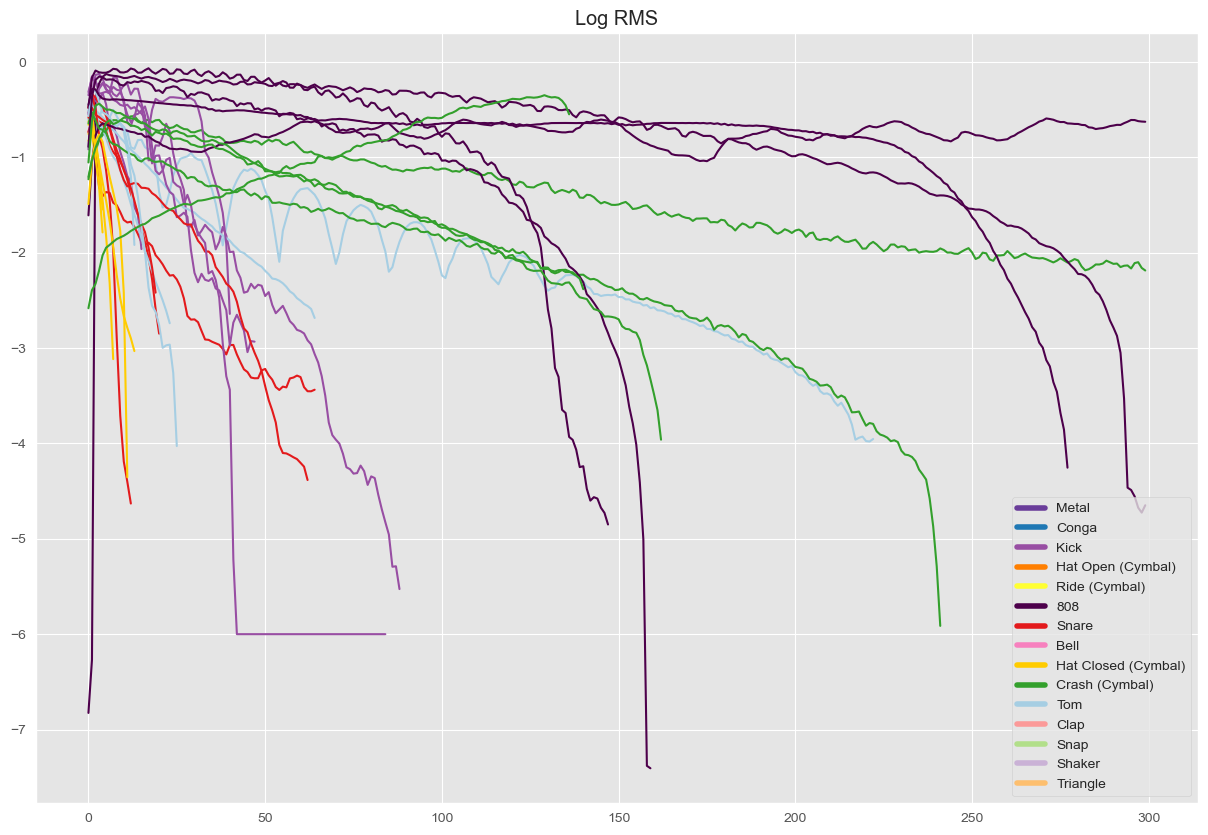

In [10]:
def get_log_rms_stats(y, frame_length=RMS_FRAME_LENGTH, hop_length=HOP_LENGTH) -> Dict[str, float]:
    """
    Calcule les statistiques du RMS d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        frame_length (int, optional): La taille de la fenêtre. Defaults to 1024. Dans cette fenêtre, on calcule le RMS, c'est à dire la racine carrée de la moyenne des carrés des échantillons.
        hop_length (int, optional): Le pas de la fenêtre (la distance entre deux fenêtres consécutives). Defaults to 512.
    """
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    log_rms = np.log10(rms) if np.min(rms) > 0 else np.log10(rms + 1e-6)

    log_sum_rms = np.sum(log_rms)
    log_mean_rms = np.mean(log_rms)
    log_max_rms = np.max(log_rms)
    log_min_rms = np.min(log_rms)
    log_rms_std = np.std(log_rms)

    log_rms_diff = np.diff(log_rms)  # shape = (1, n_frames - 1)

    log_crest_factor = log_max_rms / log_mean_rms

    return {
        'log_sum_rms': log_sum_rms,
        'log_mean_rms': log_mean_rms,
        'log_max_rms': log_max_rms,
        #'log_min_rms': log_min_rms, pas pertinent car toujours faible pour les sons
        'log_rms_std': log_rms_std,
        'log_rms_diff_mean': np.mean(np.abs(log_rms_diff)),
        'log_crest_factor': log_crest_factor
    }, log_rms


fig = plt.figure(figsize=(15, 10))
plt.title('Log RMS')
max_x = 300  # for Zoom
dicts = []
for file_path, (y, sr) in list(y_sr_examples.items()):
    stats, log_rms = get_log_rms_stats(y)
    stats['file_path'] = file_path
    dicts.append(stats)
    # reshape log_rms to (n_frames,)
    log_rms = log_rms.reshape(-1)
    log_rms = log_rms[:max_x]

    class_name = class_examples[file_path]
    plt.plot(log_rms, label=os.path.basename(file_path), color=CLASS_COLORS[class_name])

# create legend element with CLASS_COLORS
legend_elements = [Line2D([0], [0], color=CLASS_COLORS[class_name], lw=4, label=class_name) for class_name in
                   CLASS_COLORS]
plt.legend(handles=legend_elements)
plt.show()

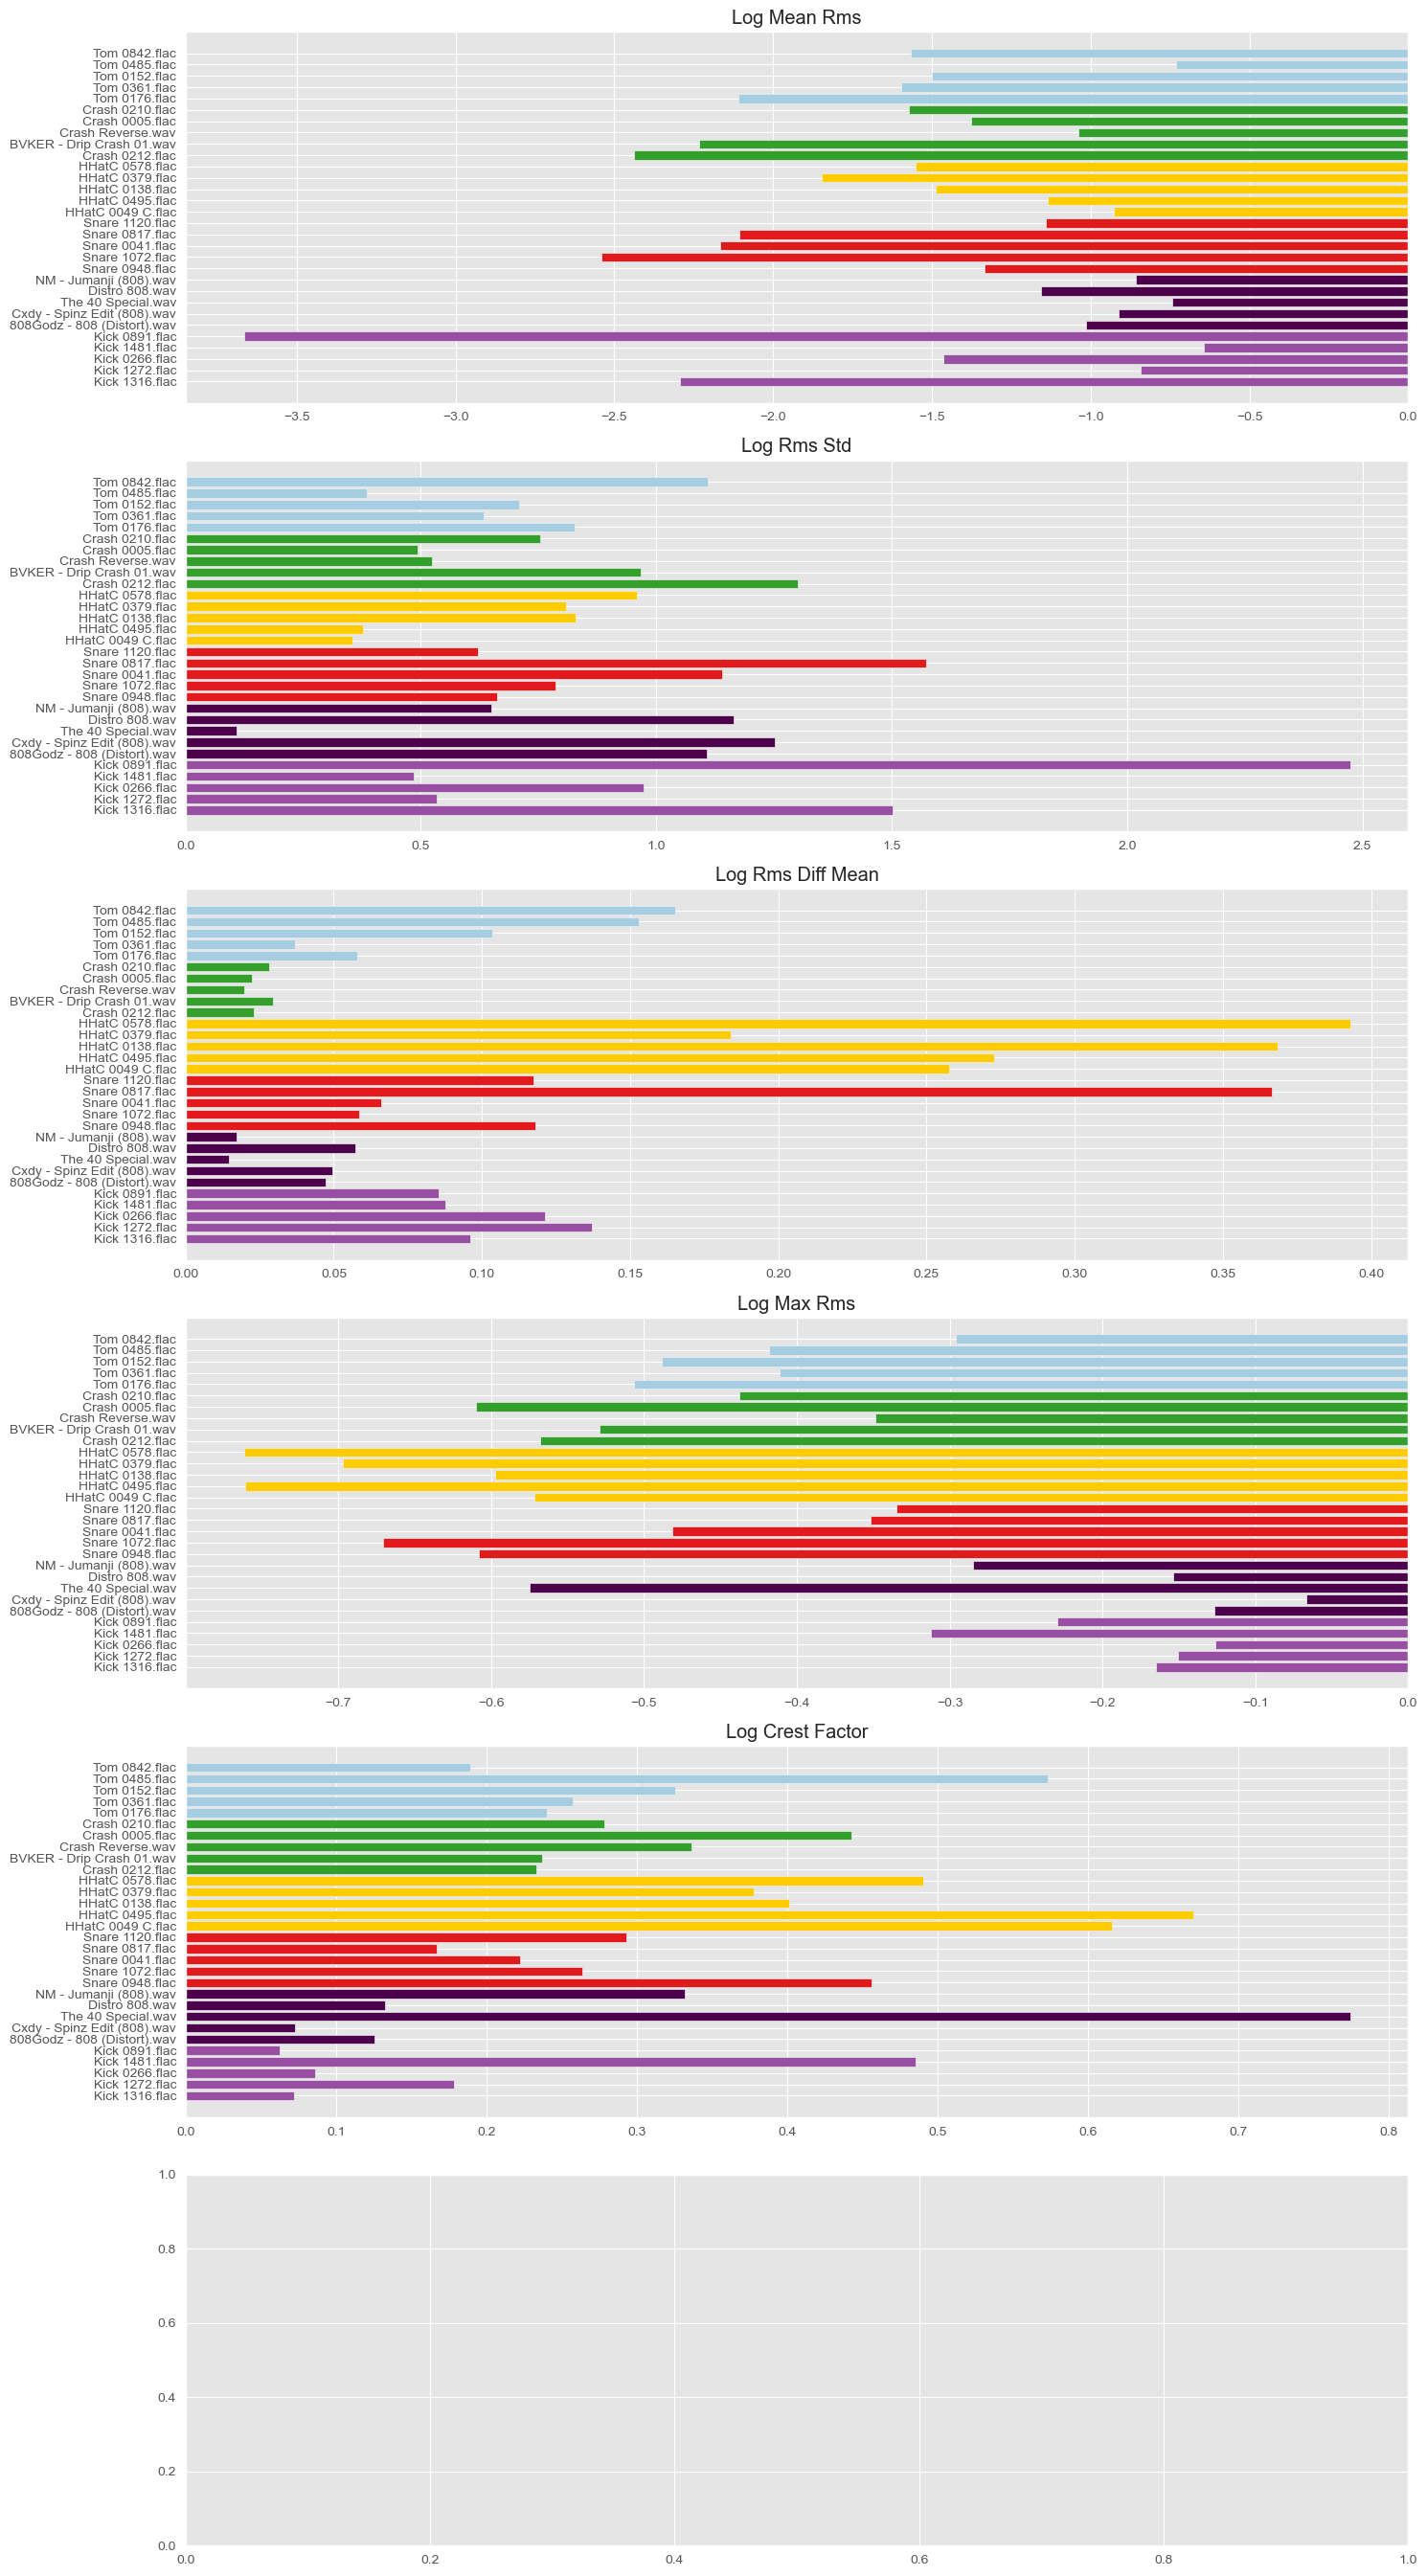

In [11]:
df_examples = pd.DataFrame(dicts)
df_examples['class'] = df_examples['file_path'].apply(lambda x: class_examples[x])
# get file names
df_examples['file_name'] = df_examples['file_path'].apply(lambda x: os.path.basename(x))

# bar plot
fig, axs = plt.subplots(6, 1, figsize=(15, 6 * 4.5))

for i, rms_stat in enumerate(
        ['log_mean_rms', 'log_rms_std', 'log_rms_diff_mean', 'log_max_rms', 'log_crest_factor']):
    # set title
    axs[i].set_title(rms_stat.replace('_', ' ').title())
    for class_name in CLASS_COLORS.keys():
        df_class = df_examples[df_examples['class'] == class_name]
        axs[i].barh(df_class['file_name'], df_class[rms_stat], label=class_name, color=CLASS_COLORS[class_name])

    #axs[i].legend()

plt.tight_layout()
plt.show()

### Zero crossing rate

f you zoom in on a waveform, you’ll see the signal oscillating above and below zero. This measures how many times that happens in one frame of audio. We can take the average across all frames, the standard deviation, or the ZCR at the loudest frame since that’s probably revealing.

- The mean and standard deviation of the zero crossing rate can be used to characterize the percussiveness of a sound.
- The loudest frame is the frame with the highest zero crossing rate.

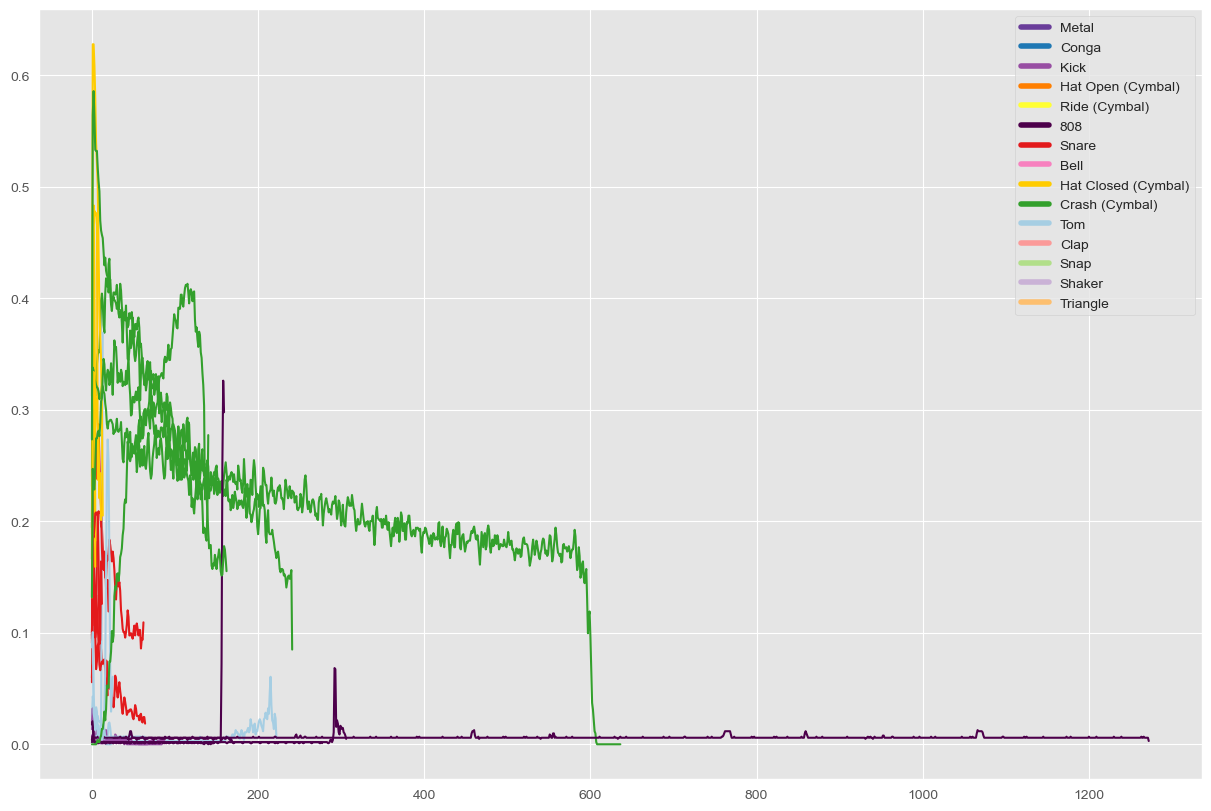

In [12]:
def get_zero_crossing_rate_stats(y, frame_length=ZCR_FRAME_LENGTH, hop_length=HOP_LENGTH) -> Dict[str, float]:
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=ZCR_FRAME_LENGTH, hop_length=HOP_LENGTH)
    loudest_frame = np.argmax(zcr)
    return {
        "zcr_sum": np.sum(zcr),
        'zcr_mean': np.mean(zcr),
        'zcr_std': np.std(zcr),
        'zcr_loudest_frame': zcr[0, loudest_frame]
    }, zcr


fig = plt.figure(figsize=(15, 10))
max_x = None  # for Zoom
dicts = []
for file_path, (y, sr) in list(y_sr_examples.items()):
    stats, zcr = get_zero_crossing_rate_stats(y)
    stats['file_path'] = file_path
    dicts.append(stats)

    # reshape zcr to (n_frames,)
    zcr = zcr.reshape(-1)
    zcr = zcr[:max_x]
    class_name = class_examples[file_path]
    plt.plot(zcr, label=os.path.basename(file_path), color=CLASS_COLORS[class_name])

# create legend element with CLASS_COLORS
legend_elements = [Line2D([0], [0], color=CLASS_COLORS[class_name], lw=4, label=class_name) for class_name in
                   CLASS_COLORS]
plt.legend(handles=legend_elements)
plt.show()

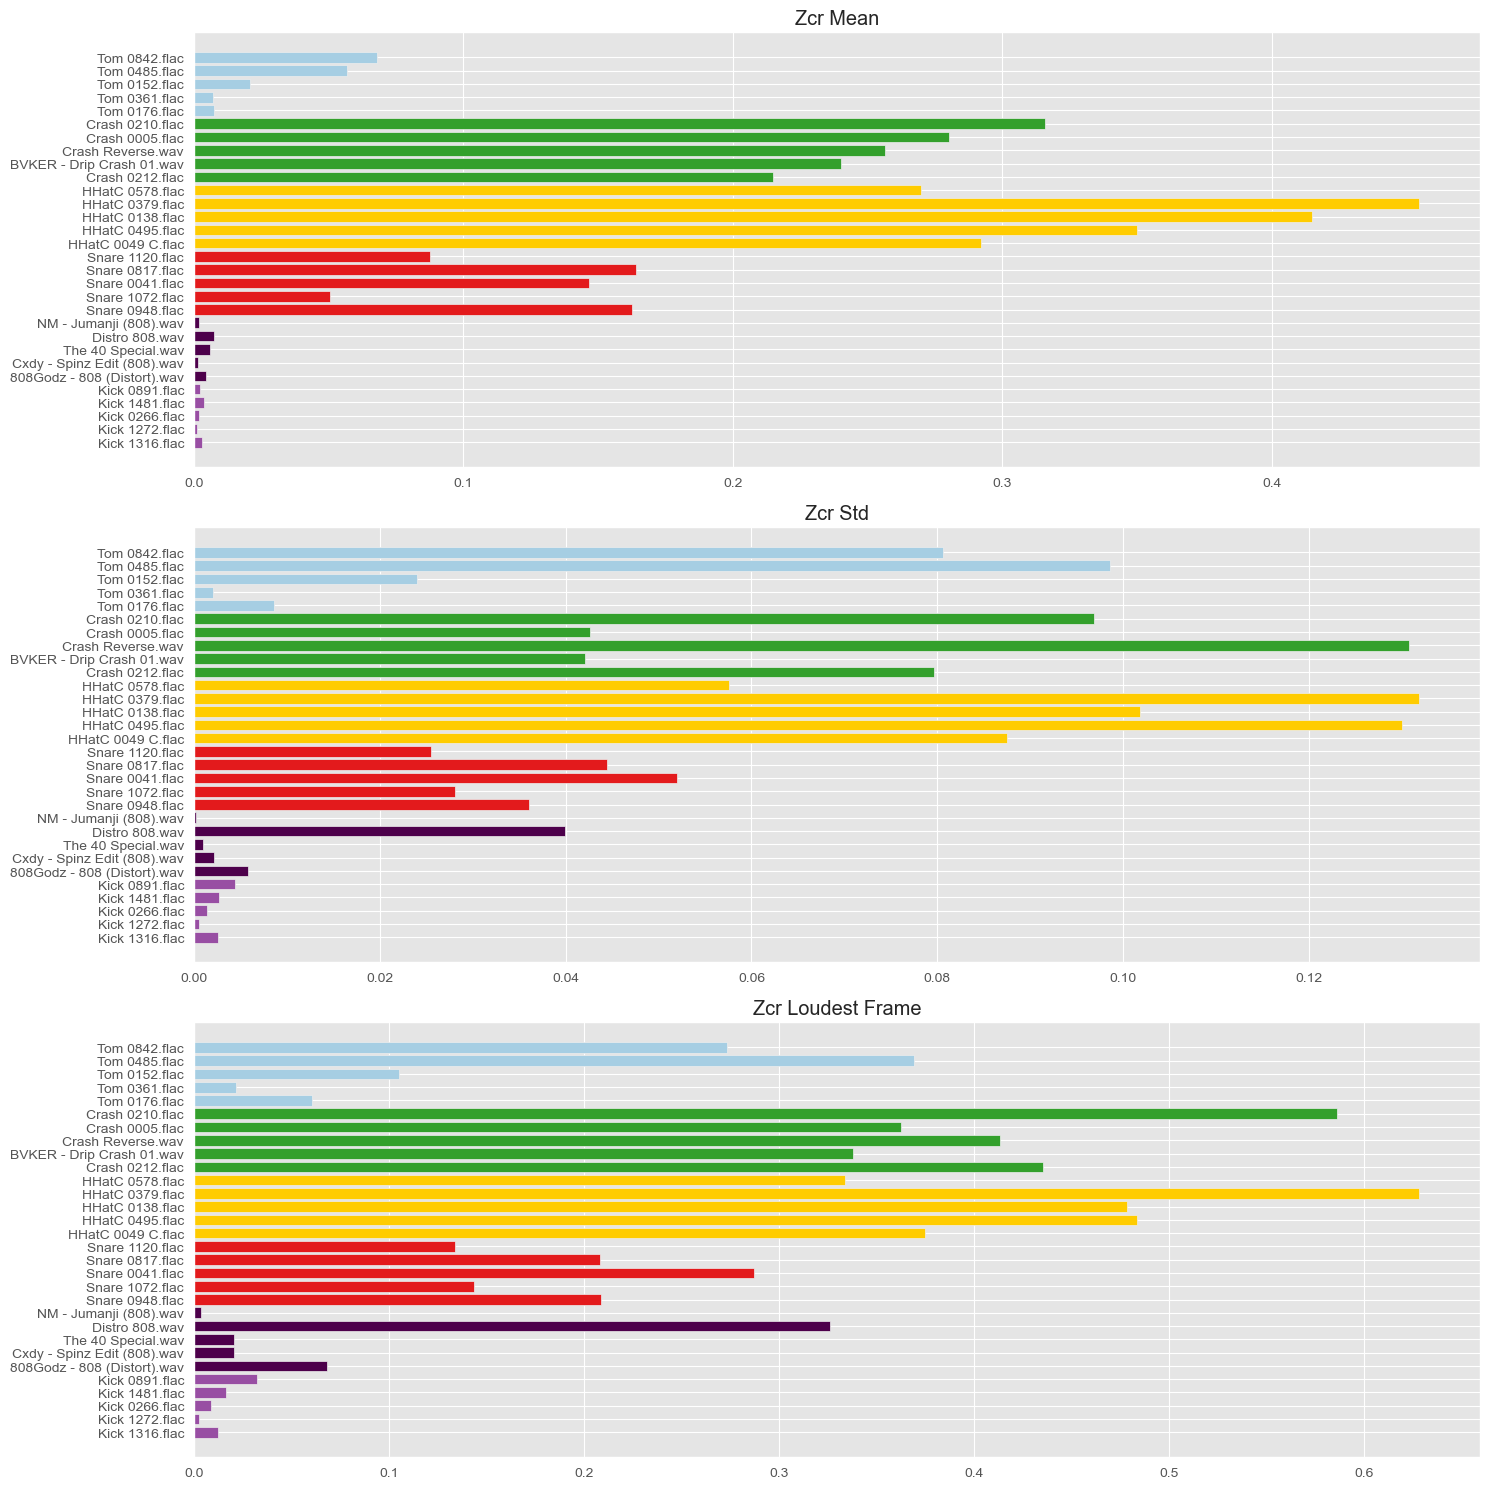

In [13]:
df_examples = pd.DataFrame(dicts)
df_examples['class'] = df_examples['file_path'].apply(lambda x: class_examples[x])
# get file names
df_examples['file_name'] = df_examples['file_path'].apply(lambda x: os.path.basename(x))

# bar zcr_mean, zcr_std, zcr_loudest_frame
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

for i, zcr_stat in enumerate(['zcr_mean', 'zcr_std', 'zcr_loudest_frame']):
    # set title
    axs[i].set_title(zcr_stat.replace('_', ' ').title())
    for class_name in CLASS_COLORS.keys():
        df_class = df_examples[df_examples['class'] == class_name]
        axs[i].barh(df_class['file_name'], df_class[zcr_stat], label=class_name, color=CLASS_COLORS[class_name])

plt.tight_layout()
plt.show()

### Temporal centroid

Le centroïde temporel, également connu sous le nom de centroïde de l'enveloppe, est une mesure qui décrit la répartition de l'énergie d'un signal audio dans le temps. Il donne une idée du "centre de gravité" de l'enveloppe du signal et peut être utilisé pour caractériser le moment où l'énergie du signal est concentrée.

Le centroïde temporel peut être une caractéristique utile pour décrire un audio, car il fournit des informations sur la répartition temporelle de l'énergie du signal. Par exemple, il peut être utilisé pour distinguer entre des sons qui ont une attaque rapide et une décroissance lente (comme un coup de tambour) et des sons qui ont une montée progressive et une décroissance rapide (comme un son de corde pincée).

100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


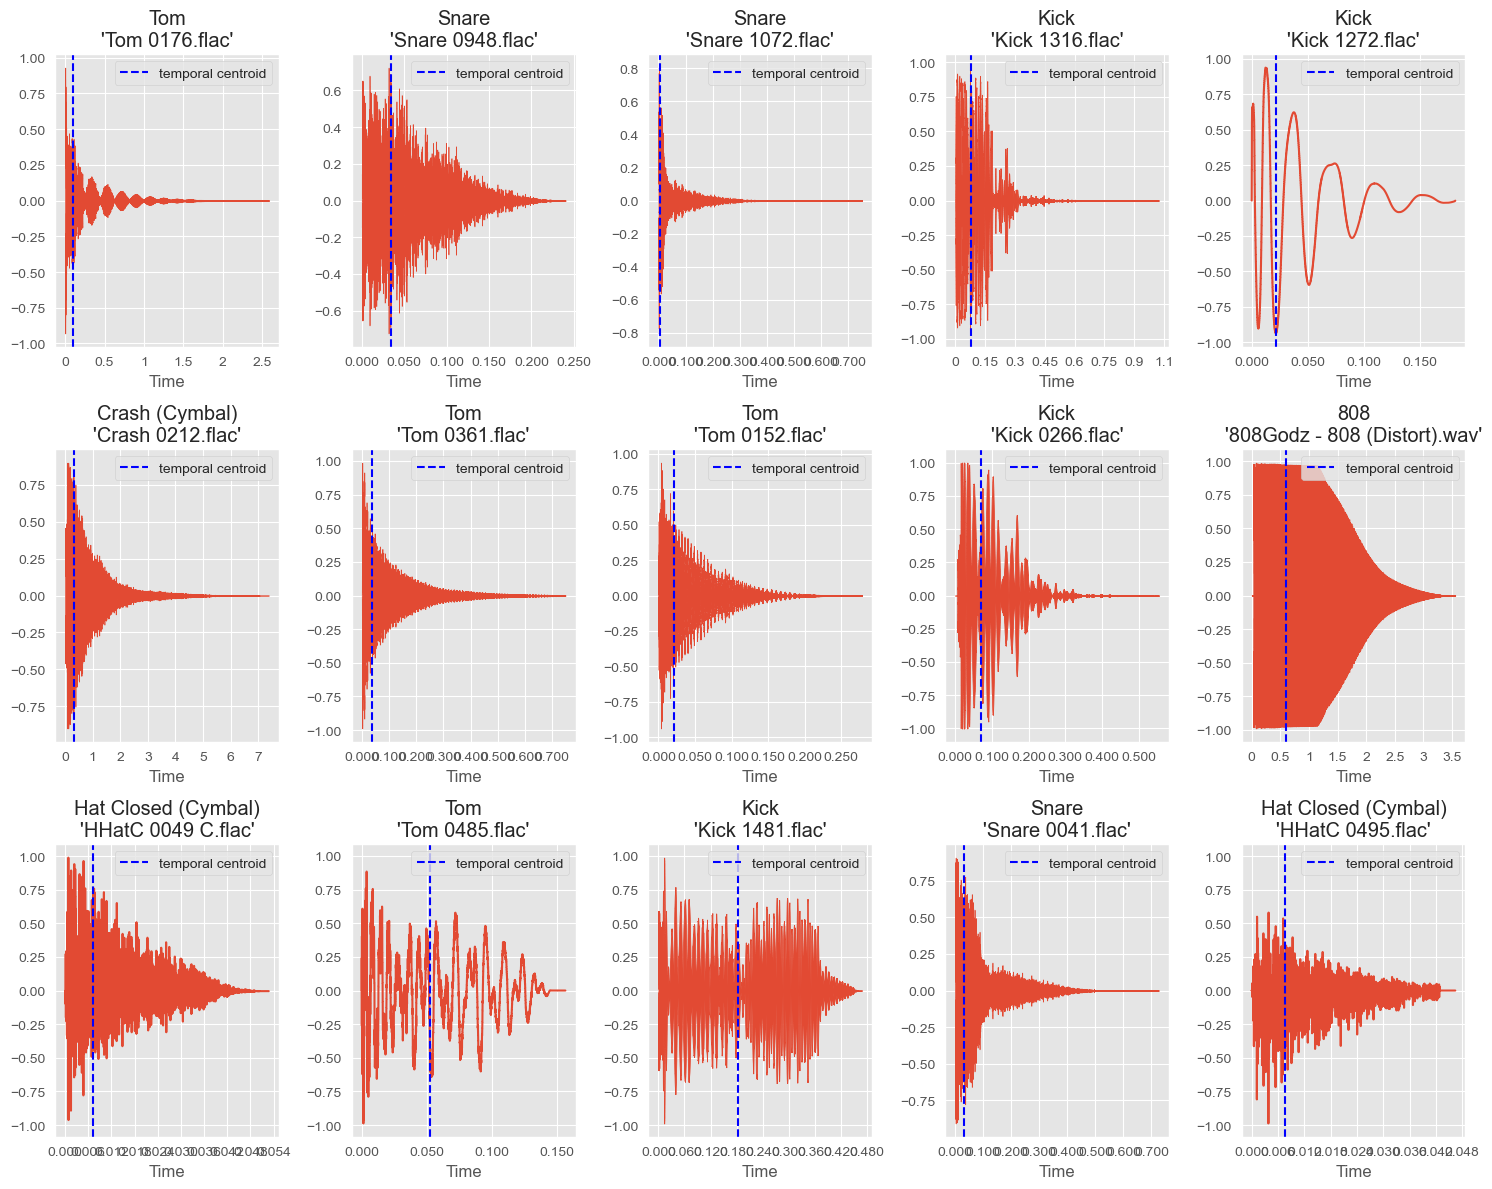

In [14]:
def get_temporal_centroid(y, sr) -> float:
    energy = np.sum(y ** 2)
    energy_cumulative = np.cumsum(y ** 2)
    half_energy_time = np.argmax(energy_cumulative >= 0.5 * energy)
    return half_energy_time / sr


max_examples = 15
n_plots = len(y_sr_examples) if max_examples is None else min(max_examples, len(y_sr_examples))
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
for idx, (file_path, (y, sr)) in tqdm(enumerate(list(y_sr_examples.items())[:max_examples]), total=n_plots):
    ax = axs[idx // n_cols, idx % n_cols]
    # plot the signal waveform and the temporal centroid
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.axvline(get_temporal_centroid(y, sr), color='blue', linestyle='--', label='temporal centroid')

    title = f"{class_examples[file_path]}\n'{os.path.basename(file_path)}'"
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

### Sound Envelope
#### Attack time

Le temps d'attaque est généralement défini comme la durée nécessaire pour qu'un signal audio atteigne son amplitude maximale à partir du début.

n prenant le logarithme du temps d'attaque, vous transformez une échelle linéaire en une échelle logarithmique. Cela peut rendre les petites différences dans les temps d'attaque plus apparentes, surtout lorsque ces différences sont importantes pour la caractérisation ou la classification des sons.

---

Travailler avec le logarithme du temps d'attaque peut être intéressant dans certaines situations, notamment lorsque vous voulez réduire la sensibilité aux variations extrêmes de temps d'attaque ou si vous voulez mieux distinguer les différences entre des temps d'attaque très courts.

Cependant, il est important de noter que l'utilisation du logarithme du temps d'attaque peut également rendre les différences entre des temps d'attaque plus longs moins importantes. Par conséquent, l'efficacité de cette transformation dépendra de l'importance relative des temps d'attaque courts et longs pour votre application spécifique.

Dans l'ensemble, il peut être utile d'expérimenter avec et sans le logarithme du temps d'attaque pour voir comment cela affecte vos résultats, et choisir l'approche qui convient le mieux à votre problème.


In [15]:
def get_attack_time(y, sr):
    """
    Calcule le temps d'attaque logarithmique d'un signal audio.

    Args:
        y (np.ndarray): Signal audio.
        sr (int): Fréquence d'échantillonnage du signal audio.

    Returns:
        float: Temps d'attaque logarithmique en secondes.
    """
    # Calcul de l'enveloppe du signal
    envelope = np.abs(hilbert(y))
    # Recherche de l'indice du pic d'enveloppe
    peak_idx = np.argmax(envelope)
    # Calcul du temps d'attaque logarithmique
    attack_time = peak_idx / float(sr)

    return attack_time


def get_log_attack_time(y, sr):
    """
    Calcule le temps d'attaque logarithmique d'un signal audio.

    Args:
        y (np.ndarray): Signal audio.
        sr (int): Fréquence d'échantillonnage du signal audio.

    Returns:
        float: Temps d'attaque logarithmique en secondes.
    """
    attack_time = get_attack_time(y, sr)
    # Conversion du temps d'attaque en échelle logarithmique
    log_attack_time = np.log(attack_time) if attack_time > 0 else np.log(1e-5)
    """
      Retourner 0 :

      Avantage : Cette valeur est simple et facile à interpréter.
      Inconvénient : Si le temps d'attaque réel est très proche de 0, la différence entre les valeurs réelles et 0 peut être importante en termes de log. Cela pourrait affecter l'analyse ou l'apprentissage automatique ultérieur.

      Retourner np.log10(1e-5) :

      Avantage : Cette valeur préserve l'échelle logarithmique et évite de créer une différence artificielle importante entre les valeurs réelles et la valeur par défaut.
      Inconvénient : La valeur np.log10(1e-5) est moins intuitive et peut nécessiter une explication supplémentaire pour être interprétée correctement.
      """
    return log_attack_time

Le temps d'attaque est généralement exprimé en secondes, donc en utilisant le logarithme base 10, nous obtenons des valeurs négatives pour des temps d'attaque inférieurs à 1 seconde. Le logarithme base 10 d'un nombre entre 0 et 1 est négatif, car il représente combien de fois 10 doit être élevé à une puissance négative pour obtenir ce nombre.

Il est courant d'utiliser des valeurs de temps d'attaque logarithmiques pour représenter la dynamique de l'enveloppe d'un signal audio, car cela peut mieux refléter la perception humaine de la différence de niveau sonore entre les attaques rapides et lentes.



#### Release time

In [16]:
def get_release_time(y, sr, threshold=0.9):
    """
    Calcule le log du temps de relâchement d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.
        threshold (float): Le seuil pour détecter le relâchement du signal audio.

    Returns:
        float: Le log du temps de relâchement.
    """
    # Calcul de l'enveloppe analytique
    y_analytic = hilbert(y)
    y_env = np.abs(y_analytic)

    if len(y_env) == 0:
        return 0, 0

    # Recherche des indices où l'enveloppe tombe en dessous du seuil
    below_threshold_indices = np.where(y_env < threshold * np.max(y_env))[0]

    # Calcul du temps de relâchement en secondes
    release_time = below_threshold_indices[0] / float(sr)

    return release_time


def get_log_release_time(y, sr, threshold=0.9):
    """
    Calcule le log du temps de relâchement d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): Le taux d'échantillonnage du signal audio.
        threshold (float): Le seuil pour détecter le relâchement du signal audio.

    Returns:
        float: Le log du temps de relâchement.
    """
    release_time = get_release_time(y, sr, threshold)
    # Conversion du temps de relâchement en échelle logarithmique
    # Calcul du log du temps de relâchement, en évitant la division par zéro

    log_release_time = np.log(release_time) if release_time > 0 else np.log(1e-5)

    # log_release_time = np.log10(release_time)

    return log_release_time

#### Plotting

100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


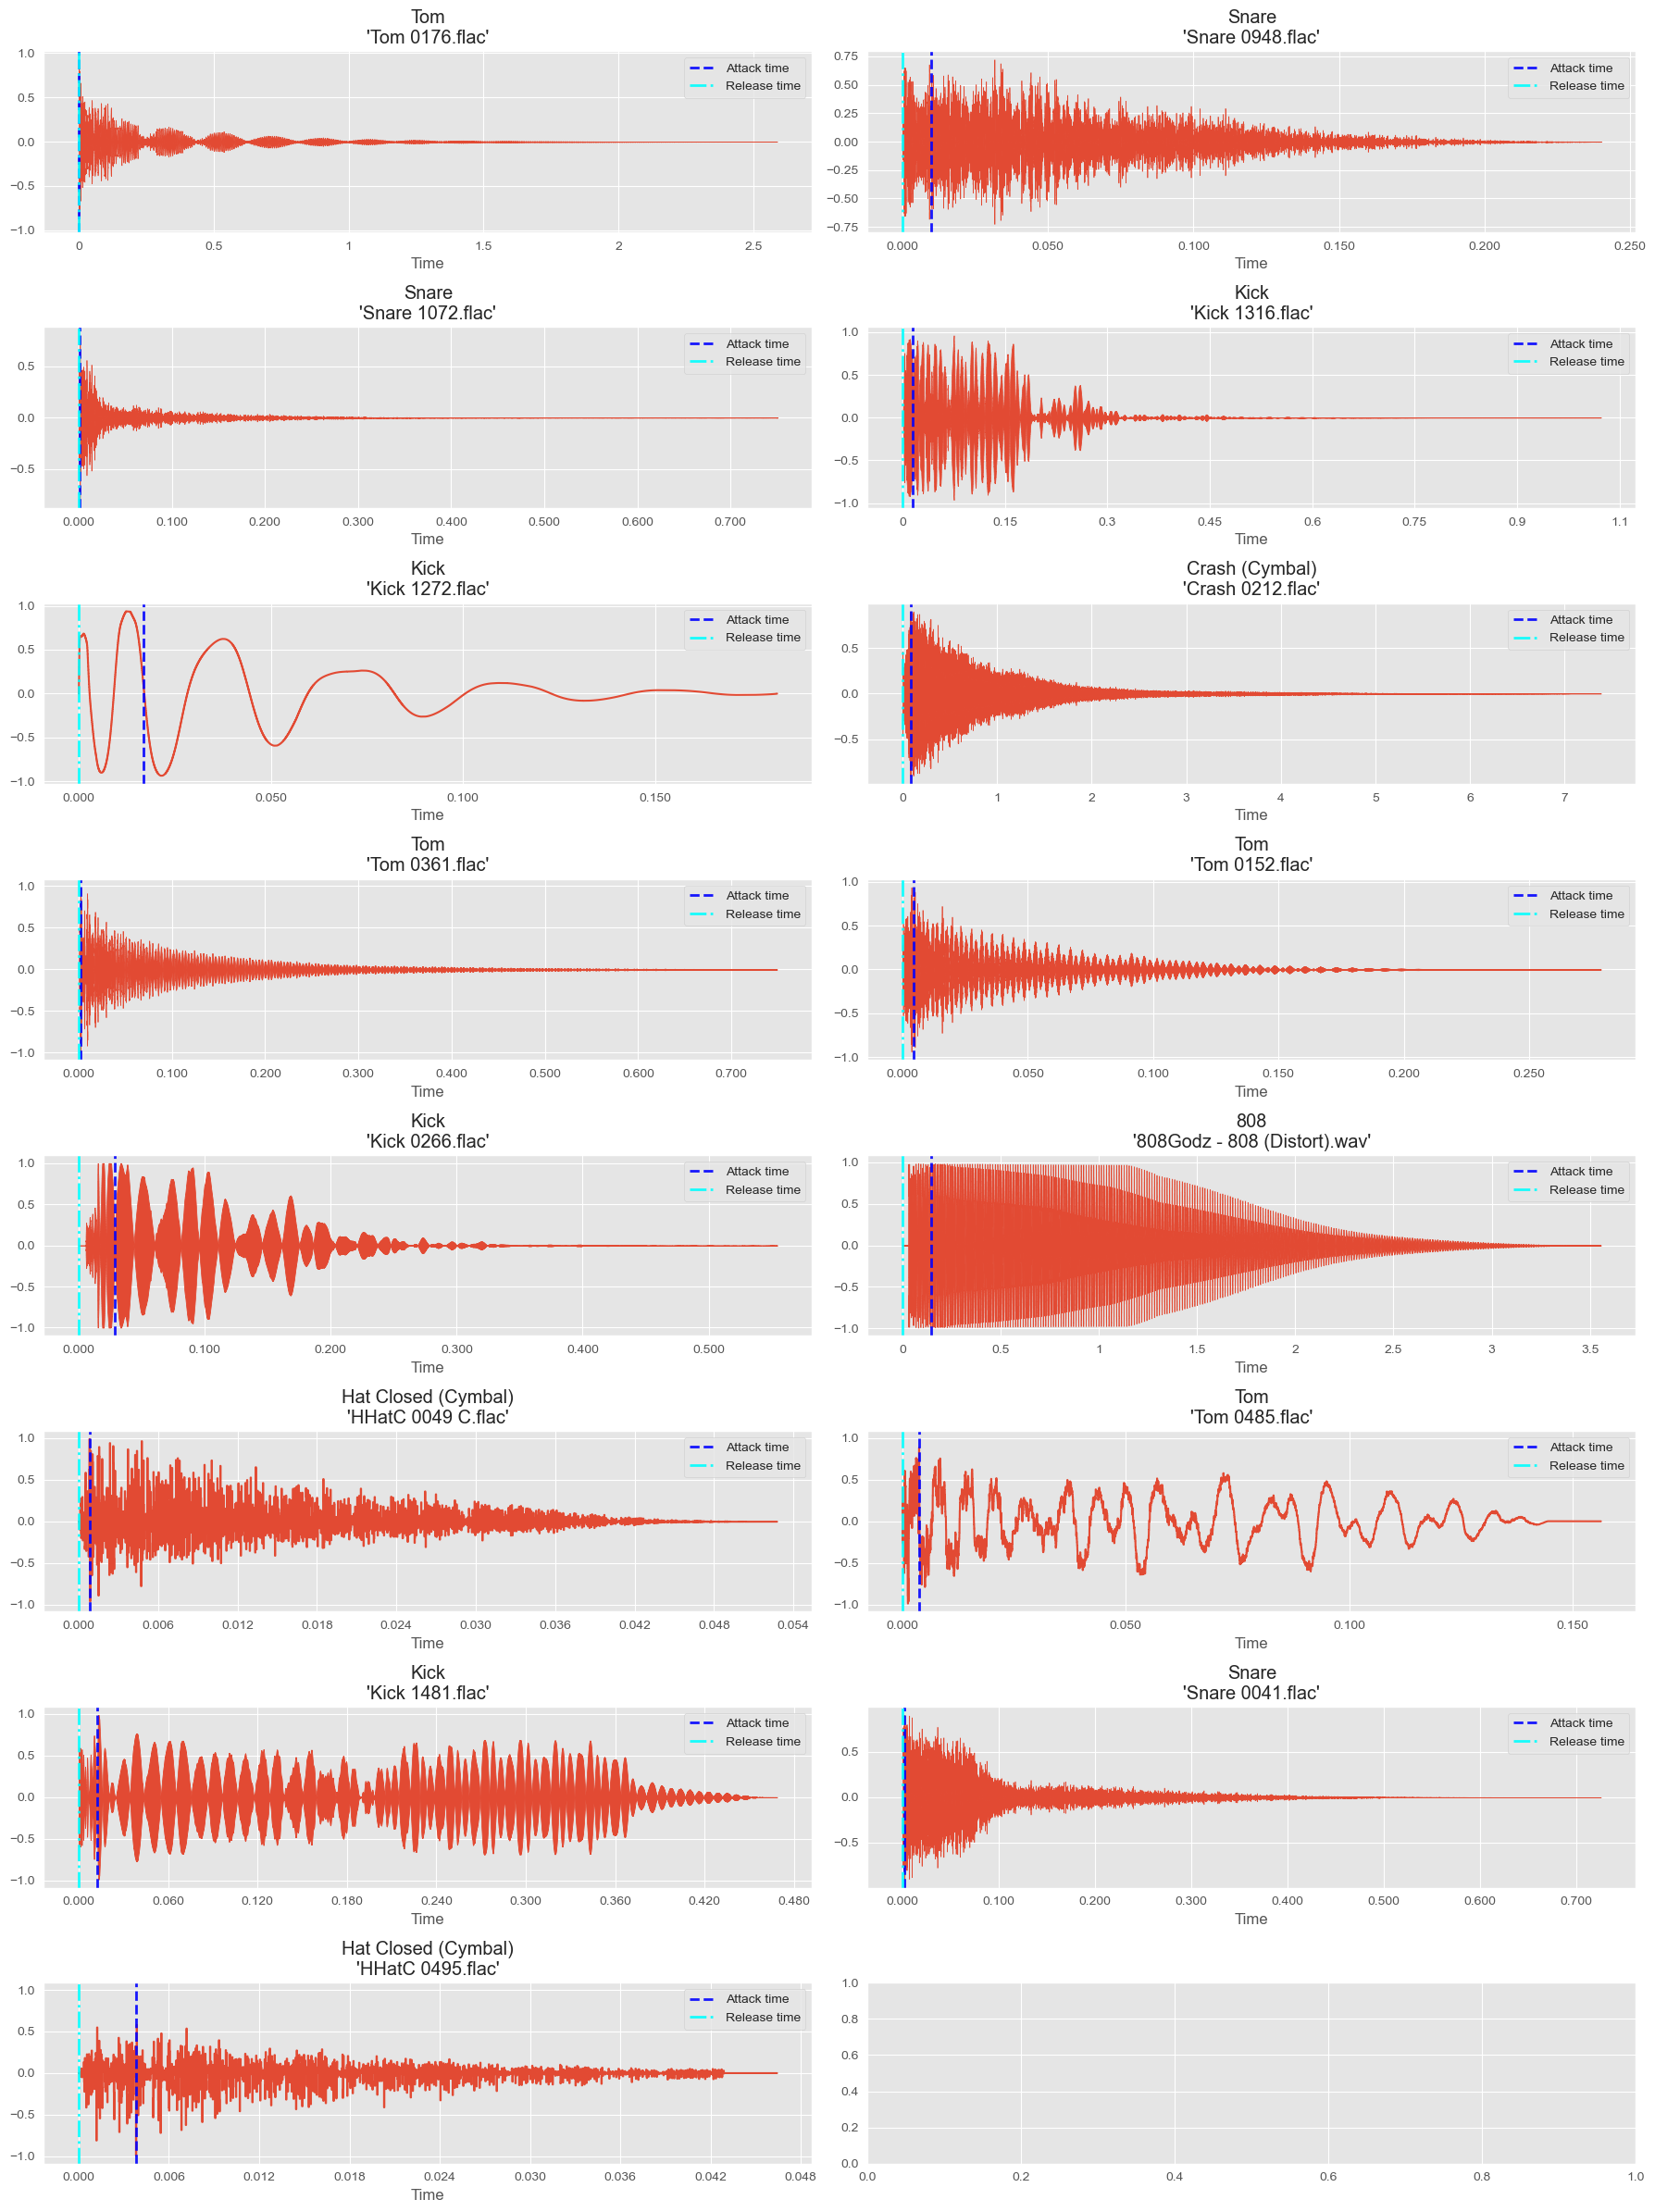

In [17]:
max_examples = 15
n_plots = len(y_sr_examples) if max_examples is None else min(max_examples, len(y_sr_examples))
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 3 * n_rows))
for idx, (file_path, (y, sr)) in tqdm(enumerate(list(y_sr_examples.items())[:max_examples]), total=n_plots):
    ax = axs[idx // n_cols, idx % n_cols]
    # Affichage du signal audio
    librosa.display.waveshow(y, sr=sr, ax=ax)

    # Calcul du temps d'attaque
    attack_time = get_attack_time(y, sr)
    # Calcul du temps de relâchement
    release_time = get_release_time(y, sr)

    # Affichage
    ax.axvline(attack_time, color='blue', label='Attack time', alpha=0.9, linewidth=2, linestyle='--')
    ax.axvline(release_time, color='cyan', label='Release time', alpha=0.9, linewidth=2, linestyle='dashdot')

    # Configuration des axes et du titre

    title = f"{class_examples[file_path]}\n'{os.path.basename(file_path)}'"
    ax.set_title(title)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Frequency-domain Features

### Pitch

Estimate the pitch of a time series using the McLeod pitch method.

In [18]:
def get_pitch(y, sr, fmin=20.0, fmax=2000):
    """
    Estime le pitch d'un signal audio en utilisant la méthode de l'autocorrélation.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): La fréquence d'échantillonnage.
        fmin (int, optional): La fréquence minimale pour estimer le pitch. Defaults to 50.
        fmax (int, optional): La fréquence maximale pour estimer le pitch. Defaults to 2000.

    Returns:
        float: Le pitch estimé en Hz.
    """
    # Calculer la fonction d'autocorrélation à court terme
    # l'auto-corrélation est calculée sur une fenêtre de 3 secondes
    autocorr = librosa.autocorrelate(y, max_size=3 * sr)

    # Trouver les limites de la région d'intérêt dans l'autocorrélation
    i_min = int(sr // fmax)
    i_max = int(sr // fmin)

    # Trouver l'index du maximum local dans la région d'intérêt
    i_peak = np.argmax(autocorr[i_min:i_max]) + i_min

    # Convertir l'index en fréquence
    f0 = float(sr) / i_peak

    return f0


def pitch_to_midi(pitch):
    """
    Convertit le pitch en Hz en midi.

    Args:
        pitch (float): Le pitch en Hz.

    Returns:
        float: Le pitch en midi.
    """
    return 69 + 12 * np.log2(pitch / 440.0)


def midi_to_note_name(midi: float):
    """
    Convertit le pitch en midi en nom de note.

    Args:
        midi (float): Le pitch en midi.

    Returns:
        str: Le nom de la note.
    """
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    return notes[int(midi) % 12] + str(int(midi) // 12 - 1)


dicts = [(file_path, os.path.basename(file_path), get_pitch(y=y, sr=sr), class_examples[file_path]) for
         file_path, (y, sr) in list(y_sr_examples.items())]
df_examples = pd.DataFrame(dicts, columns=['file_path', 'file_name', 'pitch', 'class']).set_index('file_path')
df_examples['pitch_midi'] = df_examples['pitch'].apply(pitch_to_midi)
df_examples['note_name'] = df_examples['pitch_midi'].apply(midi_to_note_name)

df_examples

file_name   
file_path                                                                         
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...                Tom 0176.flac  \
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Snare 0948.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Snare 1072.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Kick 1316.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Kick 1272.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Crash 0212.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...                Tom 0361.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...                Tom 0152.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Kick 0266.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  808Godz - 808 (Distort).wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...            HHatC 0049 C.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...                Tom 0485.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Kick 1481.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Snare 0041.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              HHatC 0495.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              HHatC 0138.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Kick 0891.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Snare 0817.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Snare 1120.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  Cxdy - Spinz Edit (808).wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...           The 40 Special.wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...    BVKER - Drip Crash 01.wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              HHatC 0379.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...                Tom 0842.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              HHatC 0578.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...               Distro 808.wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...       NM - Jumanji (808).wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...            Crash Reverse.wav   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Crash 0005.flac   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...              Crash 0210.flac   

                                                          pitch   
file_path                                                         
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455  \
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   445.454545   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   217.241379   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   159.782609   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   245.000000   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...    38.888889   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   310.563380   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   133.232628   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   124.576271   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   282.692308   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  2004.545455   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...  1520.689655   
G:\Shared drives\PFE - ING3 Mlamali\DrumClassif...   212.019231   
G:\Sha

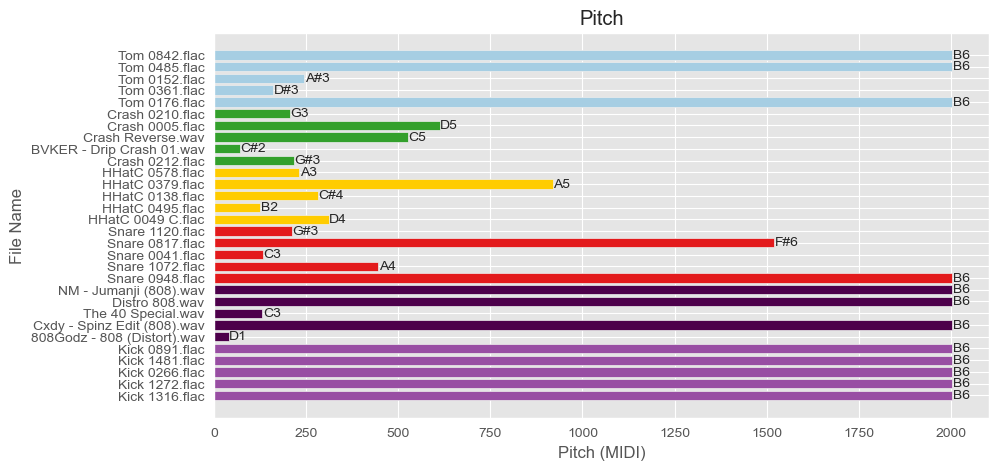

In [19]:
# bar plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# set title
plt.title("Pitch")
for class_name in CLASS_COLORS.keys():
    df_class = df_examples[df_examples['class'] == class_name]
    bars = plt.barh(df_class['file_name'], df_class["pitch"], label=class_name, color=CLASS_COLORS[class_name])
    # Ajouter les valeurs de pitch en MIDI à côté de chaque barre
    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{df_class["note_name"].iloc[i]}',
                va='center')

plt.xlabel('Pitch (MIDI)')
plt.ylabel('File Name')
plt.show()

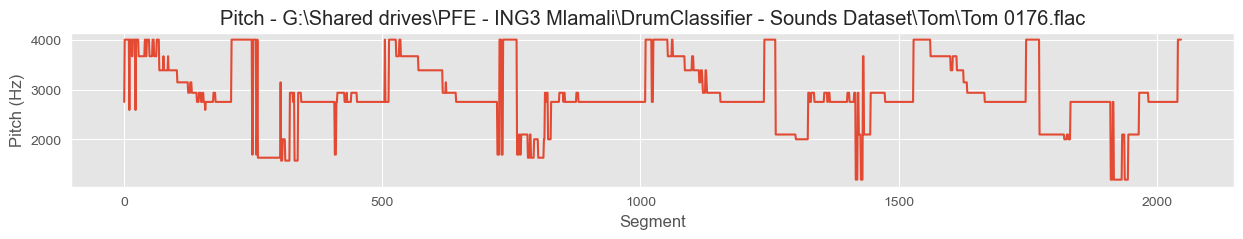

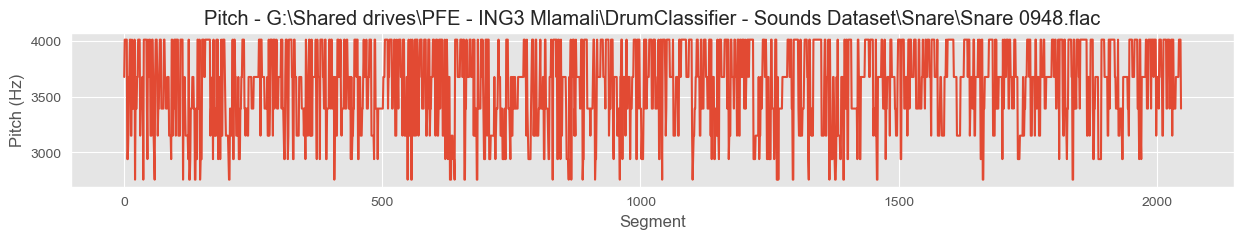

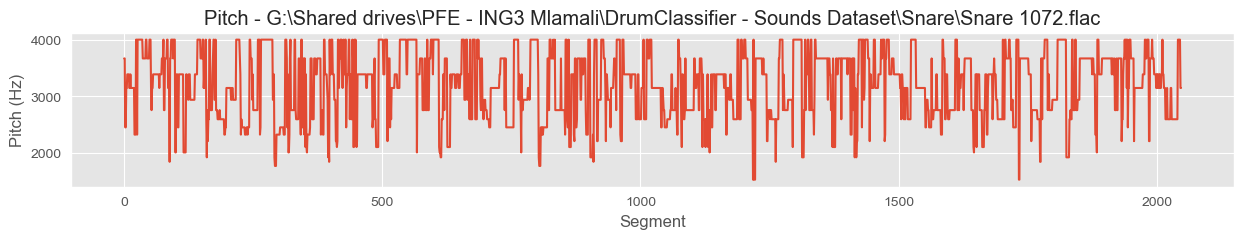

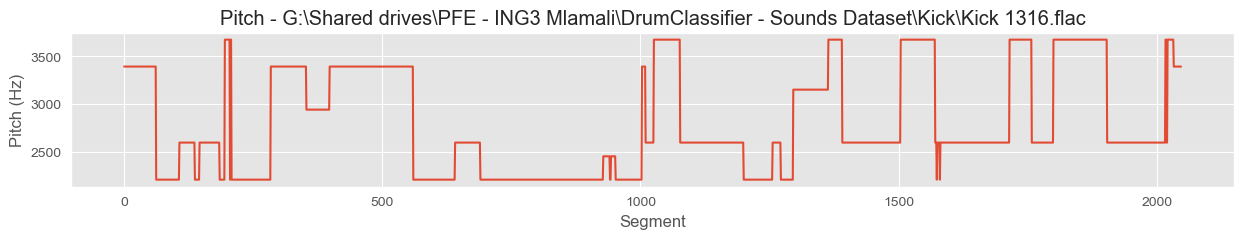

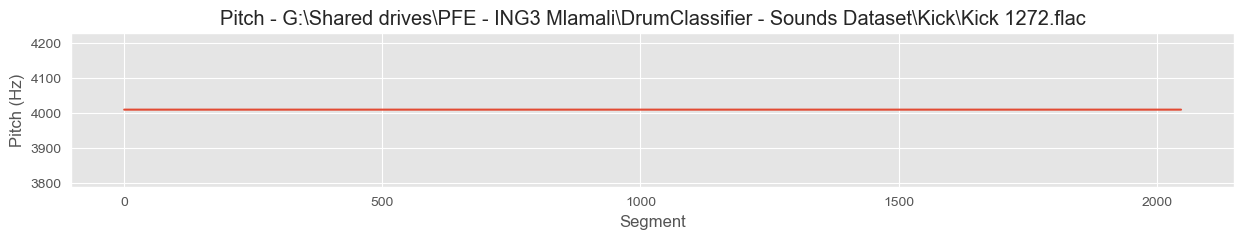

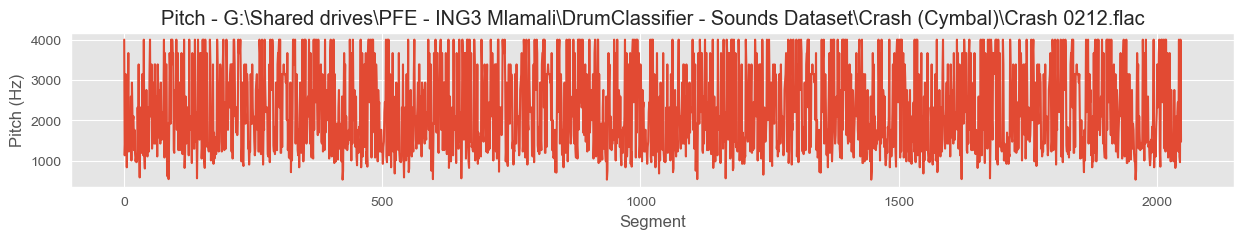

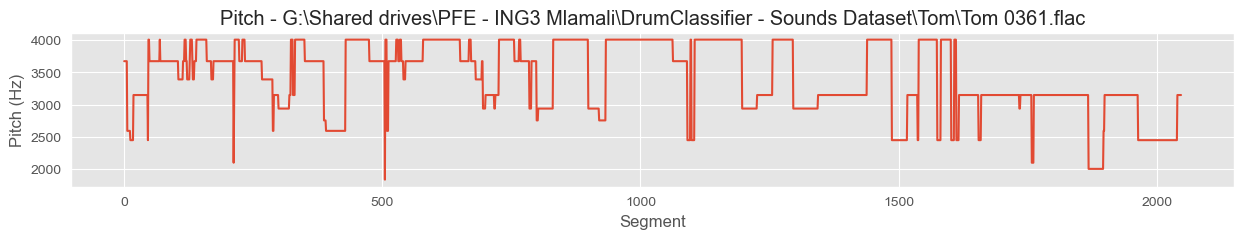

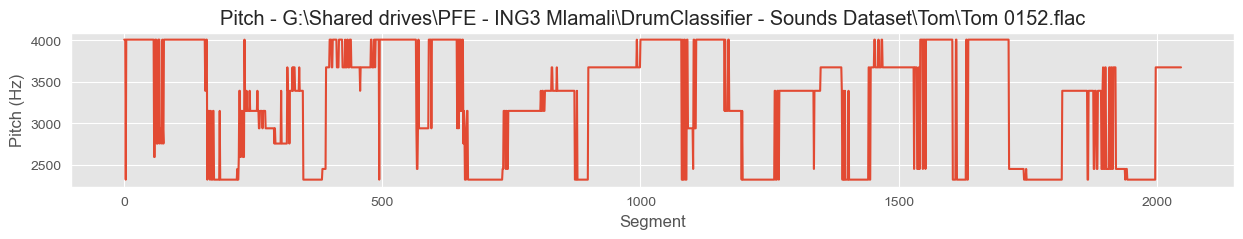

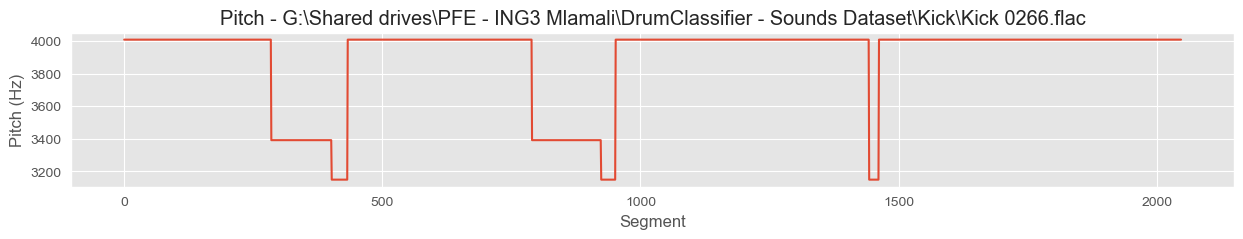

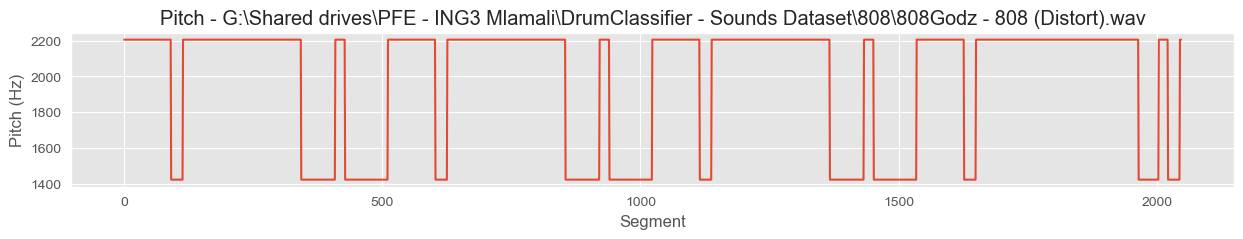

Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Closed (Cymbal)\HHatC 0049 C.flac
Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Tom\Tom 0485.flac


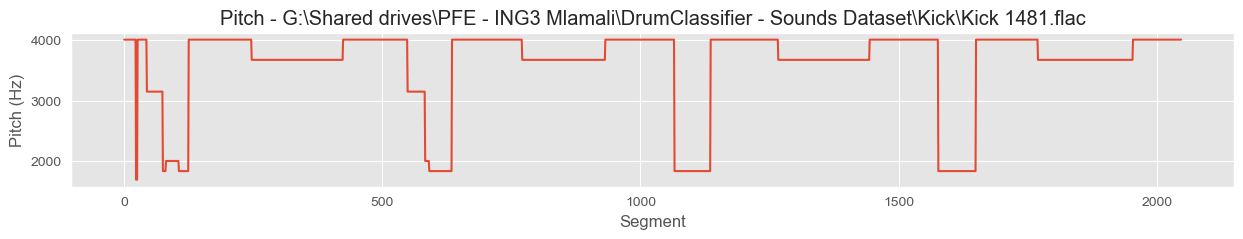

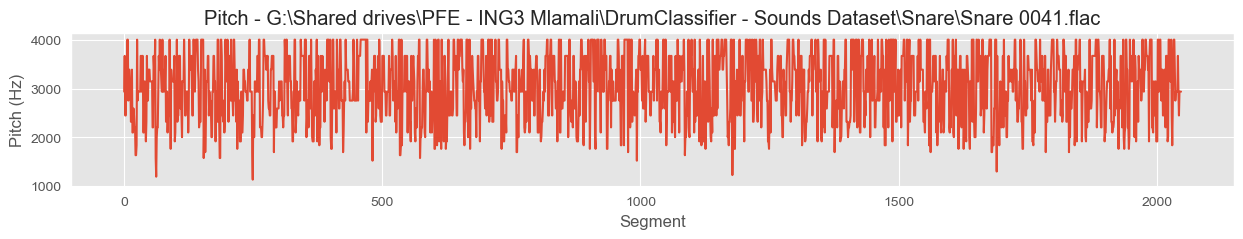

Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Closed (Cymbal)\HHatC 0495.flac
Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Closed (Cymbal)\HHatC 0138.flac


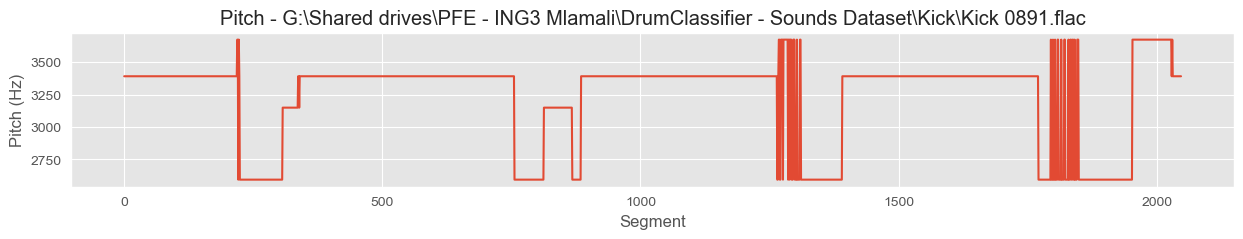

Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snare\Snare 0817.flac


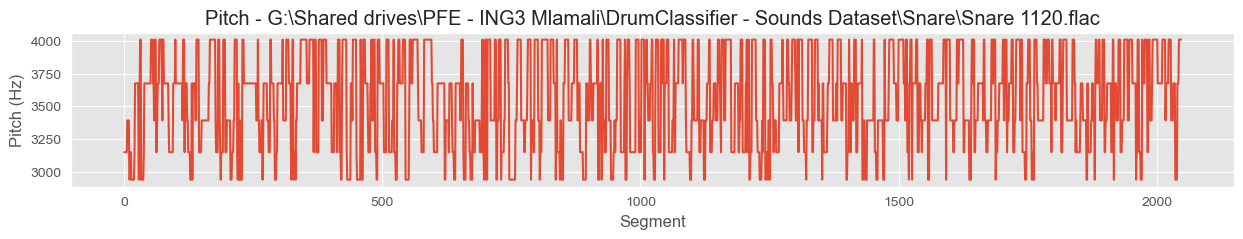

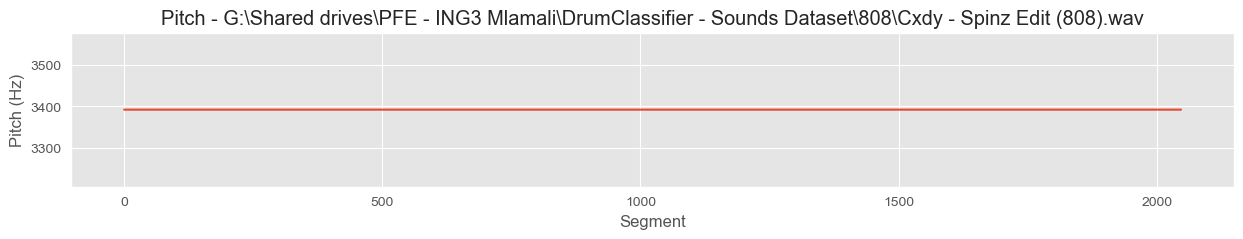

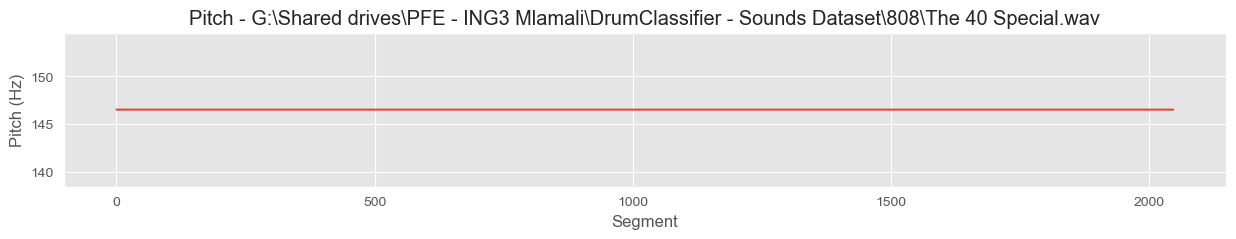

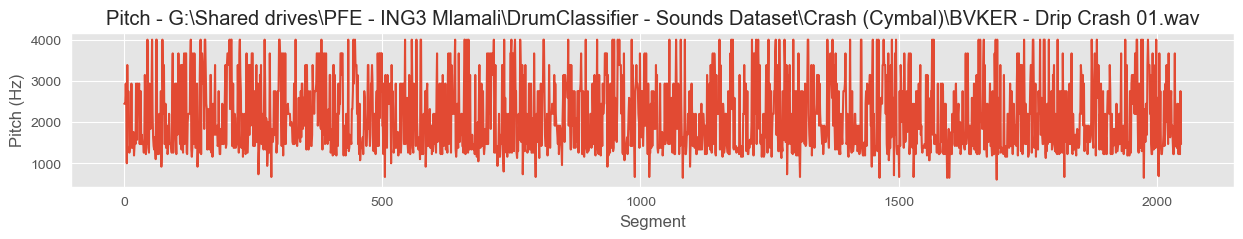

Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Closed (Cymbal)\HHatC 0379.flac


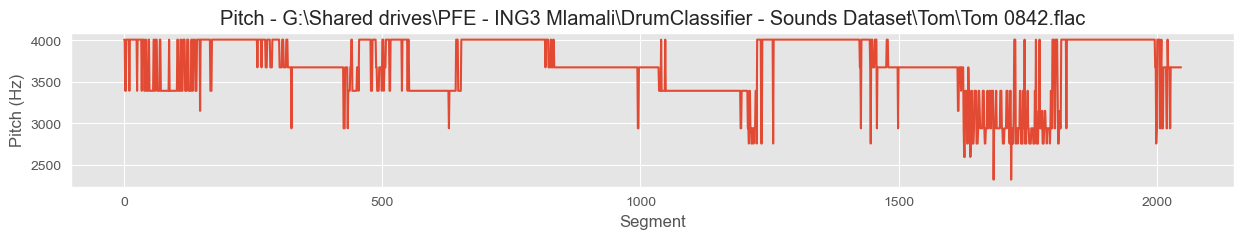

Error with G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Closed (Cymbal)\HHatC 0578.flac


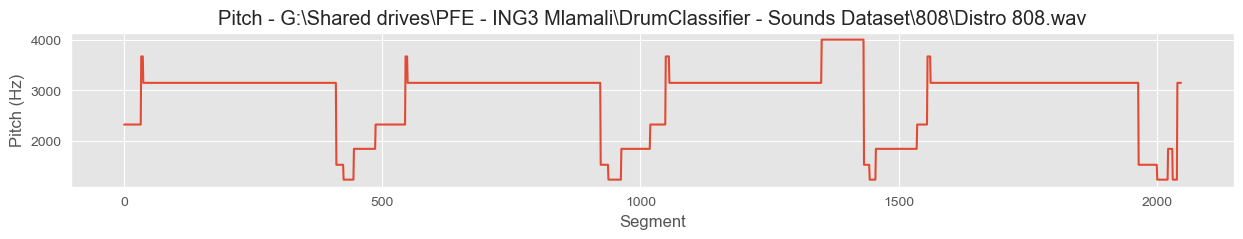

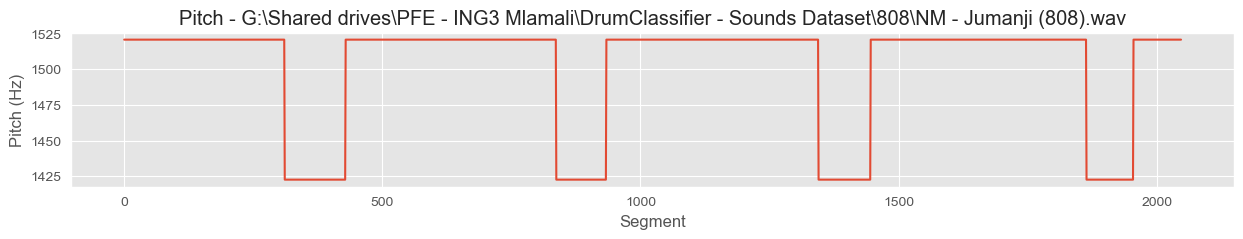

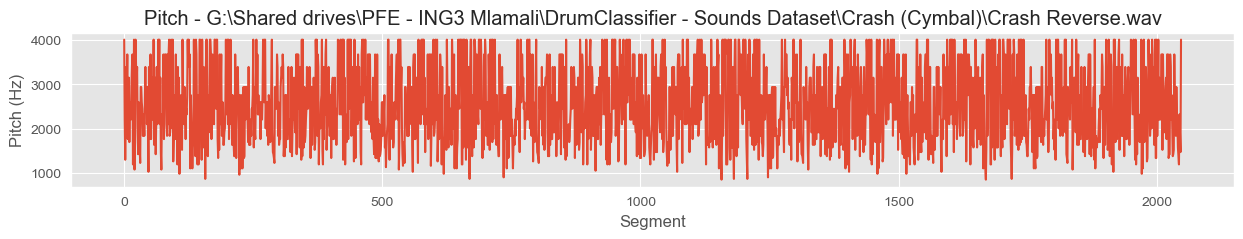

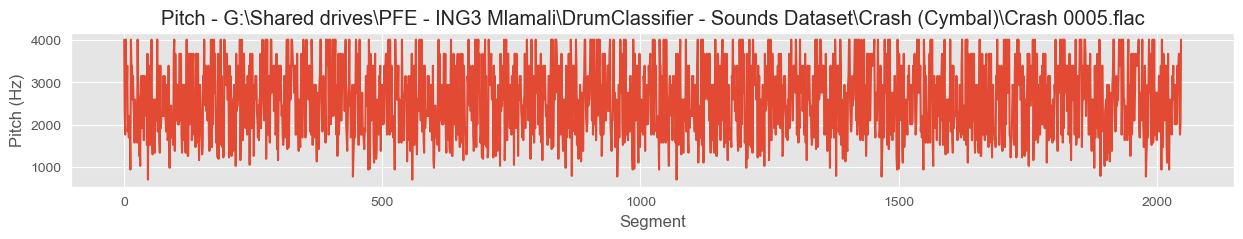

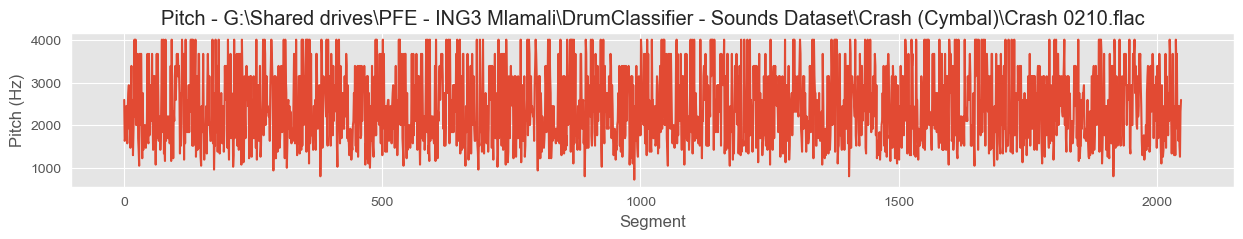

In [20]:

# get pitch each segment of a signal
def get_pitch_segments(y, sr, n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=25.0, fmax=4000.0):
    """
    Estime le pitch de chaque segment d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): La fréquence d'échantillonnage.
        n_fft (int): La taille de la fenêtre de Fourier.
        hop_length (int): Le nombre d'échantillons entre les fenêtres consécutives.
        fmin (int, optional): La fréquence minimale pour estimer le pitch. Defaults to 50.
        fmax (int, optional): La fréquence maximale pour estimer le pitch. Defaults to 2000.

    Returns:
        np.ndarray: Le pitch estimé en Hz pour chaque segment.
    """
    pitches = []
    for y_segment in librosa.util.frame(y, frame_length=n_fft, hop_length=hop_length):
        pitch = get_pitch(y=y_segment, sr=sr, fmin=fmin, fmax=fmax)
        pitches.append(pitch)

    return np.array(pitches)


for file_path, (y, sr) in list(y_sr_examples.items()):
    try:
        pitches = get_pitch_segments(y=y, sr=sr)
    except:
        print(f'Error with {file_path}')
        continue
    plt.figure(figsize=(15, 2))
    plt.title(f'Pitch - {file_path}')
    plt.plot(pitches)
    plt.xlabel('Segment')
    plt.ylabel('Pitch (Hz)')
    plt.show()

### MFCC

Les MFCC sont utiles pour la classification des drums pour plusieurs raisons :

- Invariance aux changements d'amplitude : Les MFCC sont relativement insensibles aux changements d'amplitude du signal, ce qui est important pour la classification des drums, car les enregistrements peuvent varier en volume.

- Capture des caractéristiques du timbre : Les MFCC sont capables de capturer les caractéristiques du timbre, qui sont essentielles pour différencier les différents types de drums, tels que les caisses claires, les cymbales et les toms.

- Robustesse au bruit : Les MFCC sont également assez robustes face au bruit, ce qui peut être bénéfique pour la classification des drums, car les enregistrements peuvent contenir divers types de bruit de fond.

- Compressibilité : Les MFCC offrent une représentation compacte des caractéristiques spectrales du signal audio, ce qui peut faciliter la mise en œuvre et l'entraînement des modèles de classification.

En ce qui concerne le nombre optimal de MFCC à utiliser pour la classification de sons de batterie, il n'y a pas de valeur unique qui soit "parfaite" pour tous les cas. Le nombre de MFCC à utiliser dépend des caractéristiques spécifiques des sons que vous souhaitez classifier et de la performance de votre modèle de classification.

En général, on utilise un nombre limité de MFCC (par exemple, les 12 ou 13 premiers) pour représenter un signal audio, car les MFCC supérieurs sont souvent moins pertinents pour la perception humaine et peuvent introduire du bruit. Pour la classification de sons de batterie, vous pouvez commencer par utiliser 12 ou 13 MFCC et évaluer les performances de votre modèle. Si nécessaire, vous pouvez expérimenter avec un nombre différent de MFCC pour voir si cela améliore les performances de votre modèle de classification.

Gardez à l'esprit que l'utilisation d'un plus grand nombre de MFCC peut augmenter la complexité du modèle et le temps de calcul, et pourrait potentiellement causer un surapprentissage si la taille de l'ensemble de données est limitée. Par conséquent, il est important de trouver un bon équilibre entre la représentativité des caractéristiques et la complexité du modèle.

---

- **mfcc_mean**: Les moyennes des MFCC sont souvent utilisées comme caractéristiques pour la classification audio, car elles fournissent une représentation compacte de la distribution globale des fréquences dans le signal. Conserver la moyenne des MFCC est donc une bonne idée.

- **mfcc_std**: Les écarts-types des MFCC peuvent également être utiles, car ils représentent la variabilité des fréquences dans le signal. Des signaux audio différents pourraient avoir des moyennes de MFCC similaires, mais des écarts-types très différents, ce qui peut être utile pour les distinguer.

- **mfcc_max** et **mfcc_min**: Les valeurs maximales et minimales des MFCC peuvent être moins informatives que les moyennes et les écarts-types, mais elles peuvent encore aider à capturer les extrêmes dans la distribution des fréquences. Vous pouvez les conserver, mais elles pourraient ne pas être aussi importantes que les moyennes et les écarts-types.

- **mfcc_skew** et **mfcc_kurtosis**: Ces caractéristiques mesurent l'asymétrie et la "pointe" de la distribution des MFCC, respectivement. Elles peuvent être utiles pour capturer des aspects plus subtils de la distribution des fréquences, mais elles pourraient ne pas être aussi importantes que les moyennes et les écarts-types. Vous pouvez les essayer et voir si elles améliorent les performances de votre modèle, mais elles pourraient ne pas être essentielles.

la kurtosis est une mesure qui décrit la forme d'une distribution, en mettant l'accent sur la concentration des valeurs autour de la moyenne. Dans le contexte de la classification audio, une kurtosis élevée des MFCC pourrait indiquer que le signal audio est plus concentré autour de certaines fréquences, tandis qu'une kurtosis faible pourrait indiquer une distribution plus uniforme des fréquences.


100%|██████████| 15/15 [00:00<00:00, 73.84it/s]


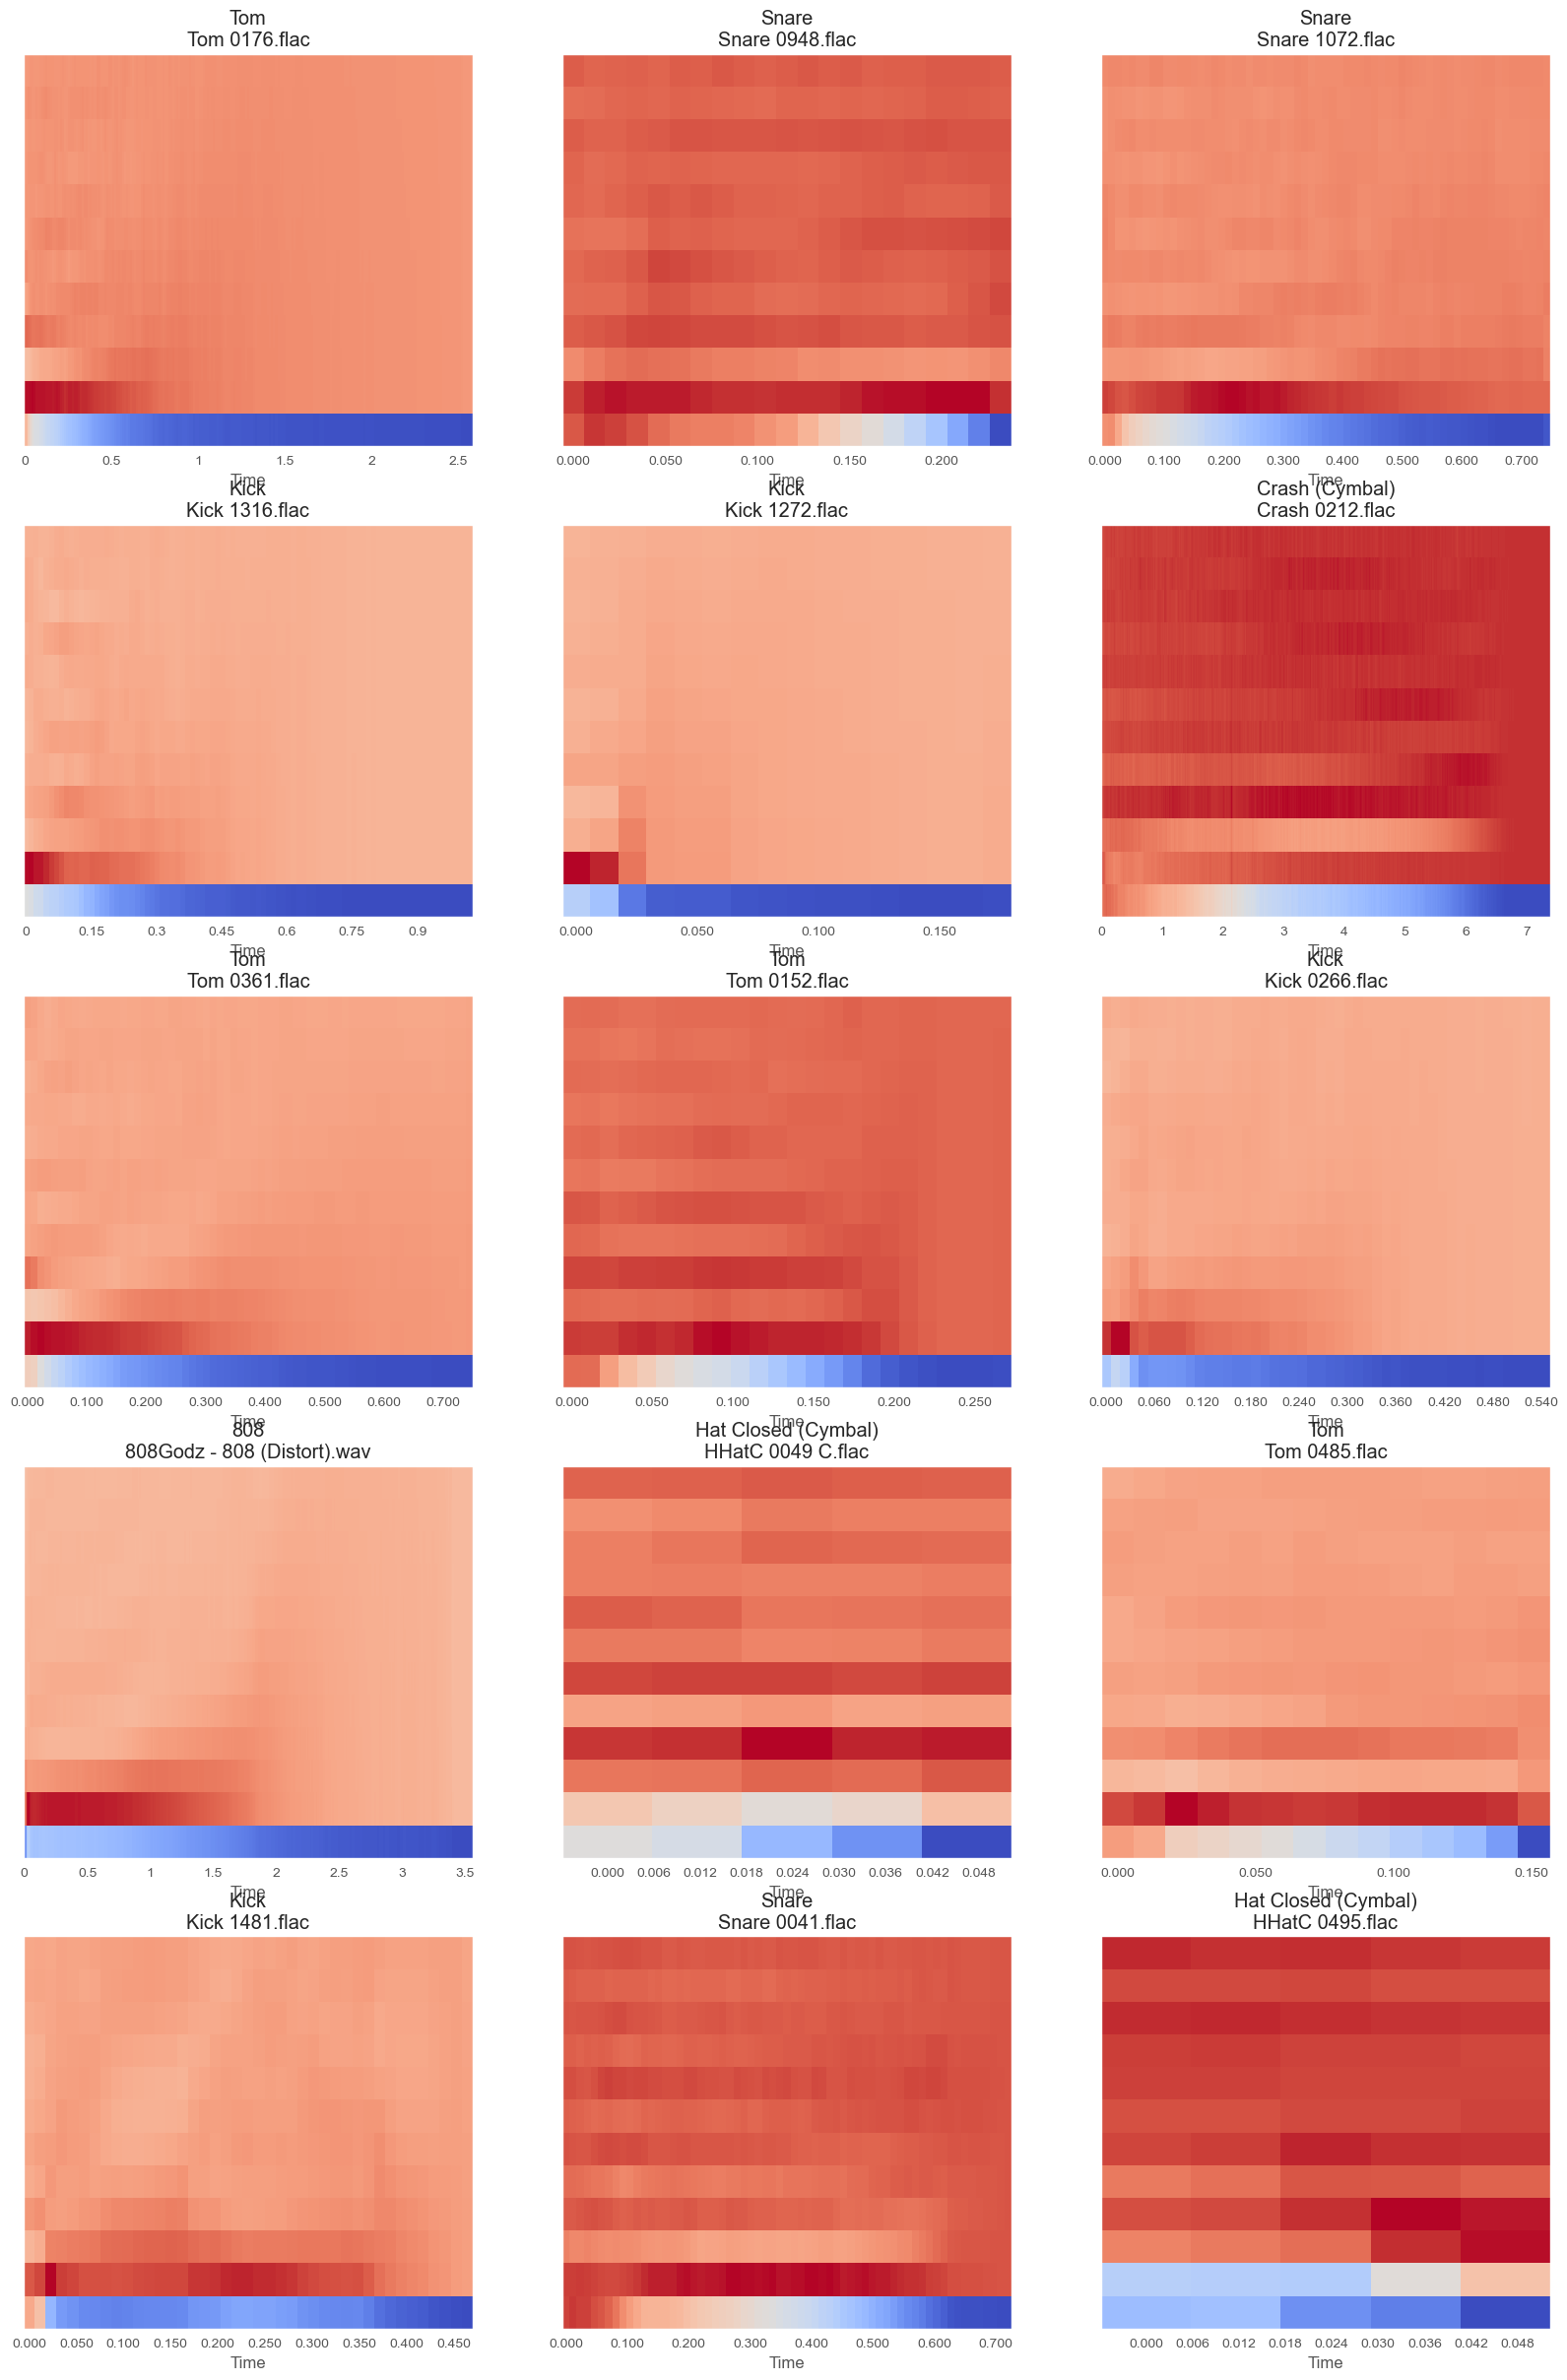

In [21]:
max_examples = 15
n_plots = len(y_sr_examples) if max_examples is None else min(max_examples, len(y_sr_examples))
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
for idx, (file_path, (y, sr)) in tqdm(enumerate(list(y_sr_examples.items())[:max_examples]), total=n_plots):
    ax = axs[idx // n_cols, idx % n_cols]

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time', ax=ax)

    class_name = class_examples[file_path]
    ax.set(title=f"{class_name}\n{os.path.basename(file_path)}")
    #ax.label_outer()
plt.show()

In [22]:
# transform a Dict[str, np.ndarray] into a Dict[str, float]
def flatten_dict(d: Dict[str, np.ndarray], start : int = 0) -> Dict[str, float]:
    # exemple {"mfcc_mean" : np.ndarray } -> [mfcc_mean_0, mfcc_mean_1, ...]
    result = {}
    for k, tab in d.items():
        for i, v in enumerate(tab,start=start):
            result[f'{k}_{i}'] = v
    return result

flatten_dict({'a': np.array([1, 2, 3]), 'b': np.array([4, 5, 6])})

{'a_0': 1, 'a_1': 2, 'a_2': 3, 'b_0': 4, 'b_1': 5, 'b_2': 6}

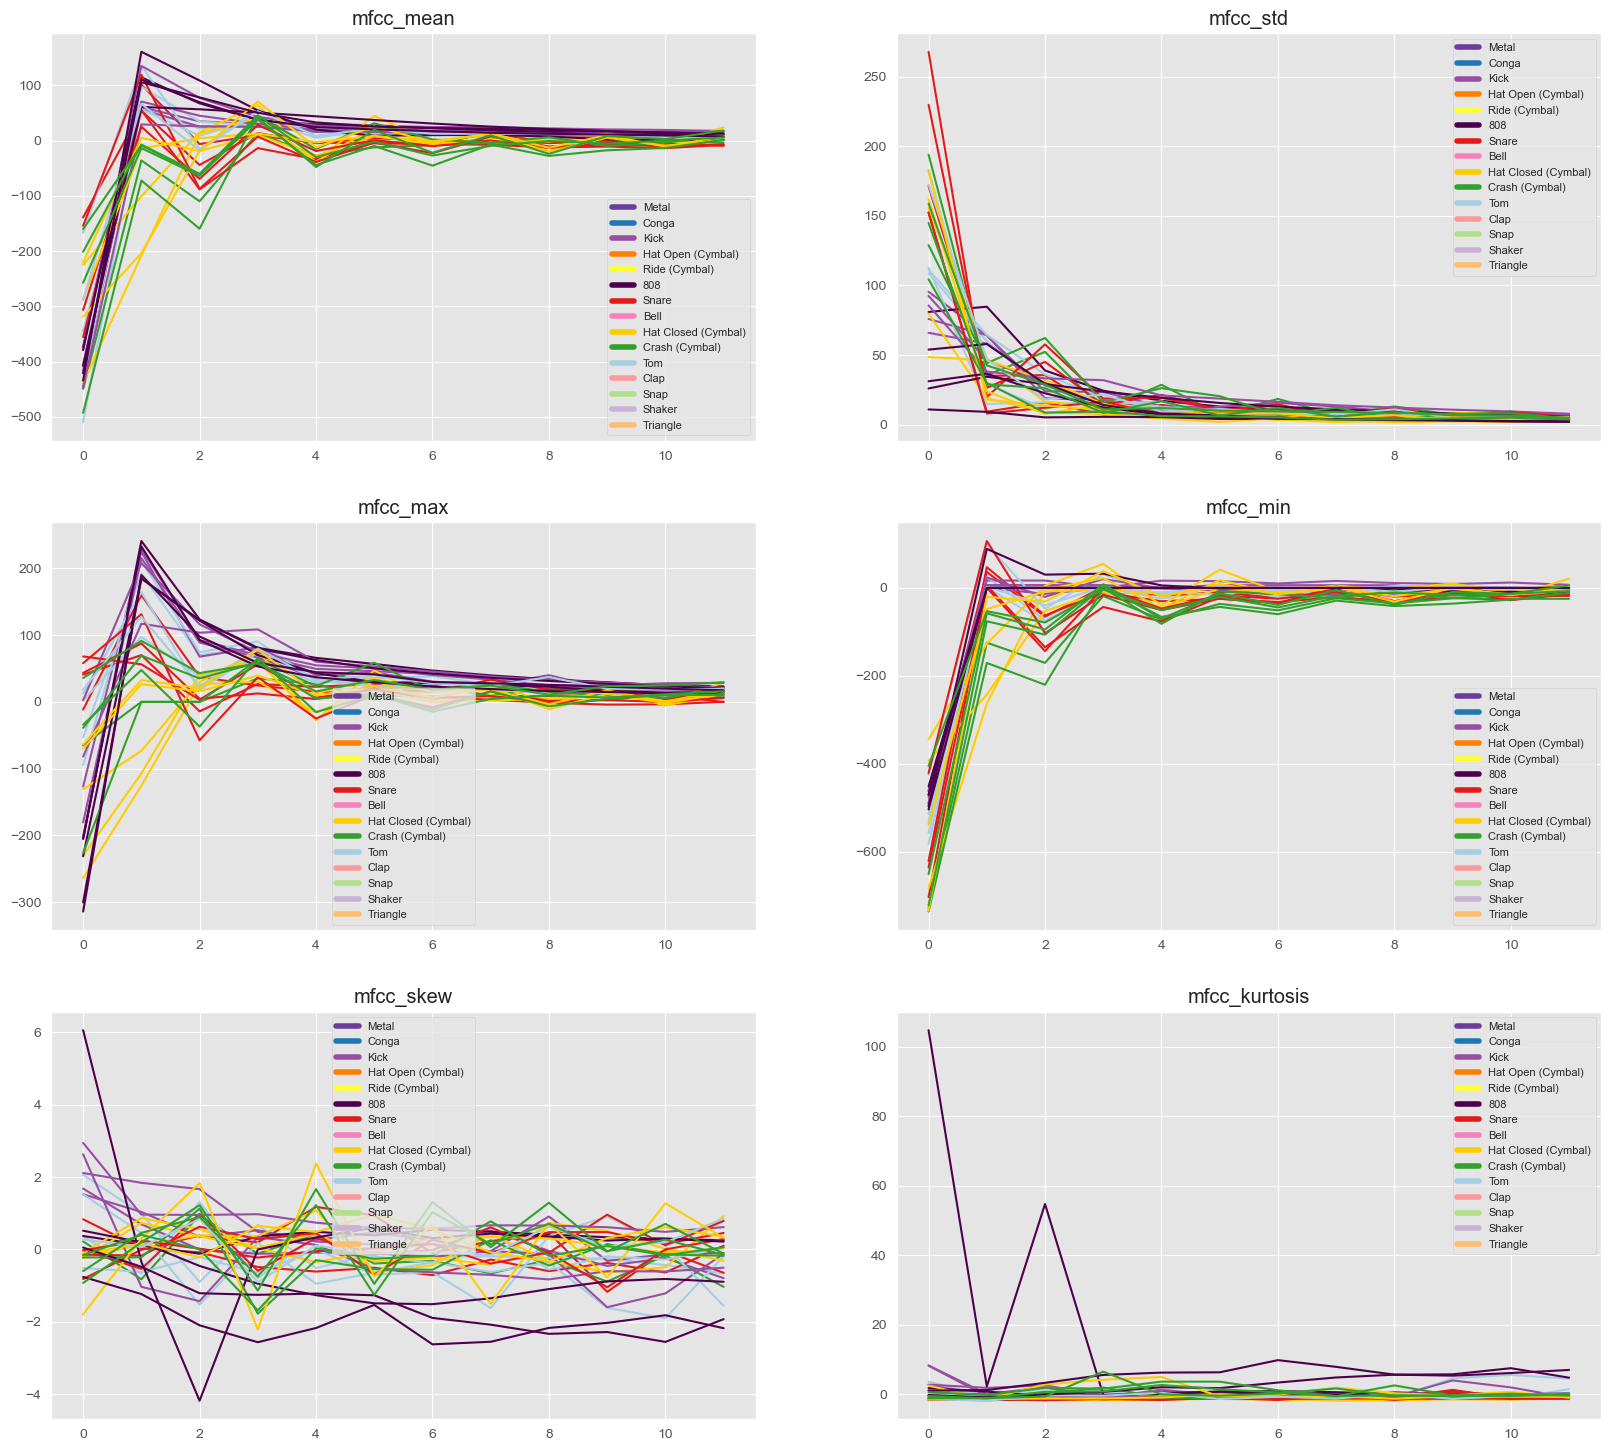

In [23]:
def get_mfcc_stats(y, sr, n_mfcc: int = N_MFCC, n_fft: int = N_FFT, hop_length: int = HOP_LENGTH) -> Dict[
    str, np.ndarray]:
    """
    Calcule les statistiques du MFCC d'un signal audio.

    Args:
        y (np.ndarray): Le signal audio.
        sr (int): La fréquence d'échantillonnage.
        n_mfcc (int, optional): Le nombre de MFCC. Defaults to 20. Un nombre plus élevé de MFCC peut fournir une représentation plus détaillée du signal audio, mais peut également augmenter le temps de calcul et la complexité du modèle de classification.
        n_fft (int, optional): La taille de la fenêtre pour la STFT. Defaults to 2048.
        hop_length (int, optional): Le pas de la fenêtre. Defaults to 512.

    Returns:
        dict: Les statistiques du MFCC.
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    mfcc_stats = {
        'mfcc_mean': mfcc.mean(axis=1),
        'mfcc_std': mfcc.std(axis=1),
        'mfcc_max': mfcc.max(axis=1),
        'mfcc_min': mfcc.min(axis=1),
        'mfcc_skew': scipy.stats.skew(mfcc, axis=1),
        'mfcc_kurtosis': scipy.stats.kurtosis(mfcc, axis=1),
    }
    return mfcc_stats




mfcc_stats_names = ['mfcc_mean', 'mfcc_std', 'mfcc_max', 'mfcc_min', 'mfcc_skew', 'mfcc_kurtosis']

# plot for each stats_name
fig, axs = plt.subplots(len(mfcc_stats_names) // 2, 2, figsize=(20, (len(mfcc_stats_names) // 2) * 6))


for idx_mfcc_stats_names, stats_name in enumerate(mfcc_stats_names):
    for _, (file_path, (y, sr)) in enumerate(list(y_sr_examples.items())[:]):
        file_name = os.path.basename(file_path)
        mfcc_stats = get_mfcc_stats(y, sr)

        # axs coordinates
        i, j = idx_mfcc_stats_names // 2, idx_mfcc_stats_names % 2
        axs[i, j].set_title(stats_name)
        class_name = class_examples[file_path]
        axs[i, j].plot(mfcc_stats[stats_name], label=f"{file_name}", color=CLASS_COLORS[class_name])
        #axs[i, j].legend()
        # legend color
        # create legend element with CLASS_COLORS
        legend_elements = [Line2D([0], [0], color=CLASS_COLORS[class_name], lw=4, label=class_name) for class_name in
                           CLASS_COLORS]

        # small size for legend
        axs[i, j].legend(handles=legend_elements, prop={'size': 8})

plt.show()

### Chroma Features

### Spectral Features

#### Spectral centroid

Le centroïde spectral est une mesure qui décrit la répartition de l'énergie d'un signal audio dans le domaine fréquentiel. Il donne une idée du "centre de gravité" du spectre du signal et peut être utilisé pour caractériser la "couleur" ou la "brillance" du son.

Le centroïde spectral peut être une caractéristique utile pour décrire un audio, car il fournit des informations sur la répartition fréquentielle de l'énergie du signal. Par exemple, il peut être utilisé pour distinguer entre des sons graves et des sons aigus, ou entre des sons "doux" et des sons "brillants".

- spec_cent_mean: moyenne du centroïde spectral
- spec_cent_std: écart-type du centroïde spectral : Il peut être utilisé pour capturer des aspects tels que la régularité ou l'irrégularité des fréquences dans le signal.

In [24]:
def get_spectral_centroid(y, sr, n_fft=N_FFT) -> Tuple[Dict[str, float], np.ndarray]:
    """Compute the spectral centroid of the signal y

    Args:
        y (np.ndarray): audio signal
        sr (int): sampling rate
        n_fft (int, optional): FFT window size. Defaults to N_FFT.

    Returns:
        Tuple[Dict[str, float], np.ndarray]: a tuple containing a dictionary with the mean and std of the spectral centroid and the spectral centroid
    """
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)
    return {"spec_cent_mean": np.mean(spec_cent), "spec_cent_std": np.std(spec_cent)}, spec_cent


#### Spectral bandwidth

Le "spectral bandwidth" (ou largeur de bande spectrale) est une mesure qui décrit la répartition des fréquences dans un signal audio. Plus précisément, il s'agit de la largeur de la distribution spectrale qui contient une certaine quantité d'énergie, généralement définie comme 50% de la puissance spectrale totale (ce qui correspond à la largeur de bande spectrale à -3 dB).

Le spectral bandwidth peut être utile pour décrire un audio, car il fournit des informations sur la répartition des fréquences et la complexité spectrale du signal. Par exemple, un signal audio avec une bande passante spectrale étroite aura une tonalité plus pure (comme une note de flûte), tandis qu'un signal avec une large bande passante spectrale aura un spectre de fréquences plus large et un son plus complexe (comme le bruit d'un tambour).


In [25]:
def get_spectral_bandwidth(y, sr, n_fft=N_FFT):
    """Compute the spectral bandwidth of the signal y

    Args:
        y (np.ndarray): audio signal
        sr (int): sampling rate
        n_fft (int, optional): FFT window size. Defaults to N_FFT.

    Returns:
        Tuple[Dict[str, float], np.ndarray]: a tuple containing a dictionary with the mean and std of the spectral bandwidth and the spectral bandwidth
    """
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft)
    return {"spec_bw_mean": np.mean(spec_bw), "spec_bw_std": np.std(spec_bw)}, spec_bw


#### Spectral flatness

Le Spectral Flatness, également connu sous le nom de Wiener Entropy, est une mesure de la "platitude" d'un spectre. Il est utilisé pour caractériser le son en termes de répartition de l'énergie dans le spectre. La platitude spectrale est définie comme le rapport de la moyenne géométrique des amplitudes spectrales à la moyenne arithmétique des amplitudes spectrales.

Le Spectral Flatness est compris entre 0 et 1 :

- Une valeur proche de 1 indique un spectre plat, c'est-à-dire que les amplitudes des fréquences sont réparties de manière égale dans tout le spectre. Un exemple de son avec une platitude spectrale élevée est le bruit blanc, où toutes les fréquences ont la même amplitude.
- Une valeur proche de 0 indique un spectre avec des pics prononcés, c'est-à-dire que certaines fréquences ont des amplitudes beaucoup plus élevées que d'autres. Les sons tonals, comme les notes de musique, ont généralement une faible platitude spectrale.
Le Spectral Flatness peut être une bonne caractéristique pour décrire un audio, en particulier lorsqu'il est utilisé en combinaison avec d'autres caractéristiques spectrales telles que le centroïde spectral, la largeur de bande spectrale et le déclin spectral. Il peut aider à différencier les sons tonals des sons bruités et à caractériser la répartition des fréquences dans un signal audio.

In [26]:
def get_spectral_flatness(y, sr, n_fft=N_FFT) -> Tuple[Dict[str, float], np.ndarray]:
    """Compute the spectral flatness of the signal y

    Args:
        y (np.ndarray): audio signal
        sr (int): sampling rate
        n_fft (int, optional): FFT window size. Defaults to N_FFT.

    Returns:
        Tuple[Dict[str, float], np.ndarray]: a tuple containing a dictionary with the mean and std of the spectral flatness and the spectral flatness
    """
    spec_flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft)
    return {"spec_flatness_mean": np.mean(spec_flatness), "spec_flatness_std": np.std(spec_flatness)}, spec_flatness

#### Spectral rolloff

Le Spectral Rolloff est une mesure qui indique la fréquence en dessous de laquelle se trouve une certaine fraction (généralement 85% ou 95%) de l'énergie spectrale totale d'un signal audio. C'est une caractéristique souvent utilisée pour décrire le contenu fréquentiel d'un signal et peut être utile dans la classification audio.

 Le paramètre roll_percent détermine le pourcentage d'énergie spectrale totale à prendre en compte pour le calcul du Spectral Rolloff.

- roll_percent=0.85: Le Spectral Rolloff est calculé en trouvant la fréquence en dessous de laquelle 85% de l'énergie spectrale totale est concentrée. Cela donne une idée de la répartition des fréquences plus élevées dans le signal.
- roll_percent=0.15: Le Spectral Rolloff est calculé en trouvant la fréquence en dessous de laquelle 15% de l'énergie spectrale totale est concentrée. Cela donne une idée de la répartition des fréquences plus basses dans le signal.

Par exemple, si vous travaillez sur un ensemble de données audio contenant des instruments avec des contenus fréquentiels très différents (comme des basses et des flûtes), le Spectral Rolloff pourrait être une caractéristique utile pour distinguer ces instruments en se basant sur leur distribution d'énergie spectrale.

In [27]:
def get_spectral_rolloff(y, sr, roll_percent=0.85, n_fft=N_FFT) -> Tuple[Dict[str, float], np.ndarray]:
    """Compute the spectral rolloff of the signal y

    Args:
        y (np.ndarray): audio signal
        sr (int): sampling rate
        roll_percent (float, optional): percentage of the total energy. Defaults to 0.85.
        n_fft (int, optional): FFT window size. Defaults to N_FFT.

    Returns:
        Tuple[Dict[str, float], np.ndarray]: a tuple containing a dictionary with the mean and std of the spectral rolloff and the spectral rolloff
    """
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=roll_percent, n_fft=n_fft)
    return {"spec_rolloff_mean": np.mean(spec_rolloff), "spec_rolloff_std": np.std(spec_rolloff)}, spec_rolloff

#rolloff_15 = spectral_rolloff(y1, sr1, roll_percent=0.15)
#rolloff_85 = spectral_rolloff(y1, sr1, roll_percent=0.85)

#### Spectral contrast

Le Spectral Contrast est une mesure qui décrit la différence d'énergie entre les pics (zones de forte énergie) et les vallées (zones de faible énergie) du spectre d'un signal audio. Cette caractéristique peut être utile pour décrire les différentes bandes de fréquences présentes dans un signal et leur distribution en termes d'énergie.

Le Spectral Contrast est calculé en divisant le spectre en plusieurs bandes de fréquences et en évaluant la différence d'énergie entre les pics et les vallées de chaque bande. Les bandes sont généralement choisies de manière à ce qu'elles couvrent l'ensemble du spectre. Le contraste spectral donne ainsi une représentation locale du spectre, mettant en évidence les zones où il y a des différences importantes d'énergie entre les fréquences adjacentes.

Le Spectral Contrast peut être particulièrement utile pour différencier les sons produits par différents types d'instruments de musique ou de percussions, car chaque instrument peut avoir des caractéristiques spectrales uniques (pics et vallées) qui peuvent être mises en évidence par le contraste spectral.

Par exemple, supposons que nous voulons distinguer les sons de guitare acoustique, de guitare électrique et de piano. Chacun de ces instruments a des harmoniques et des résonances différentes, ce qui se traduit par des variations dans la distribution d'énergie entre les bandes de fréquences. Le Spectral Contrast peut capturer ces variations et aider à discriminer les sons produits par ces instruments.

La guitare acoustique, par exemple, peut avoir un contraste spectral élevé dans les fréquences moyennes en raison de la richesse des harmoniques produites par les cordes en vibration. La guitare électrique, en revanche, peut présenter un contraste spectral plus élevé dans les fréquences aiguës en raison de l'amplification et des effets électroniques qui accentuent certaines fréquences. Le piano, avec sa grande variété de cordes et sa grande étendue de fréquences, peut présenter un contraste spectral unique qui varie en fonction de la tessiture et du timbre du son produit.

In [28]:
def get_spectral_contrast(y, sr, n_fft=N_FFT) -> Tuple[Dict[str, float], np.ndarray]:
    """Compute the spectral contrast of the signal y

    Args:
        y (np.ndarray): audio signal
        sr (int): sampling rate
        n_fft (int, optional): FFT window size. Defaults to N_FFT.

    Returns:
        Tuple[Dict[str, float], np.ndarray]: a tuple containing a dictionary with the mean and std of the spectral contrast and the spectral contrast
    """
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft)
    return {"spec_contrast_mean": np.mean(spec_contrast), "spec_contrast_std": np.std(spec_contrast)}, spec_contrast

#### Plotting

100%|██████████| 15/15 [00:02<00:00,  7.37it/s]


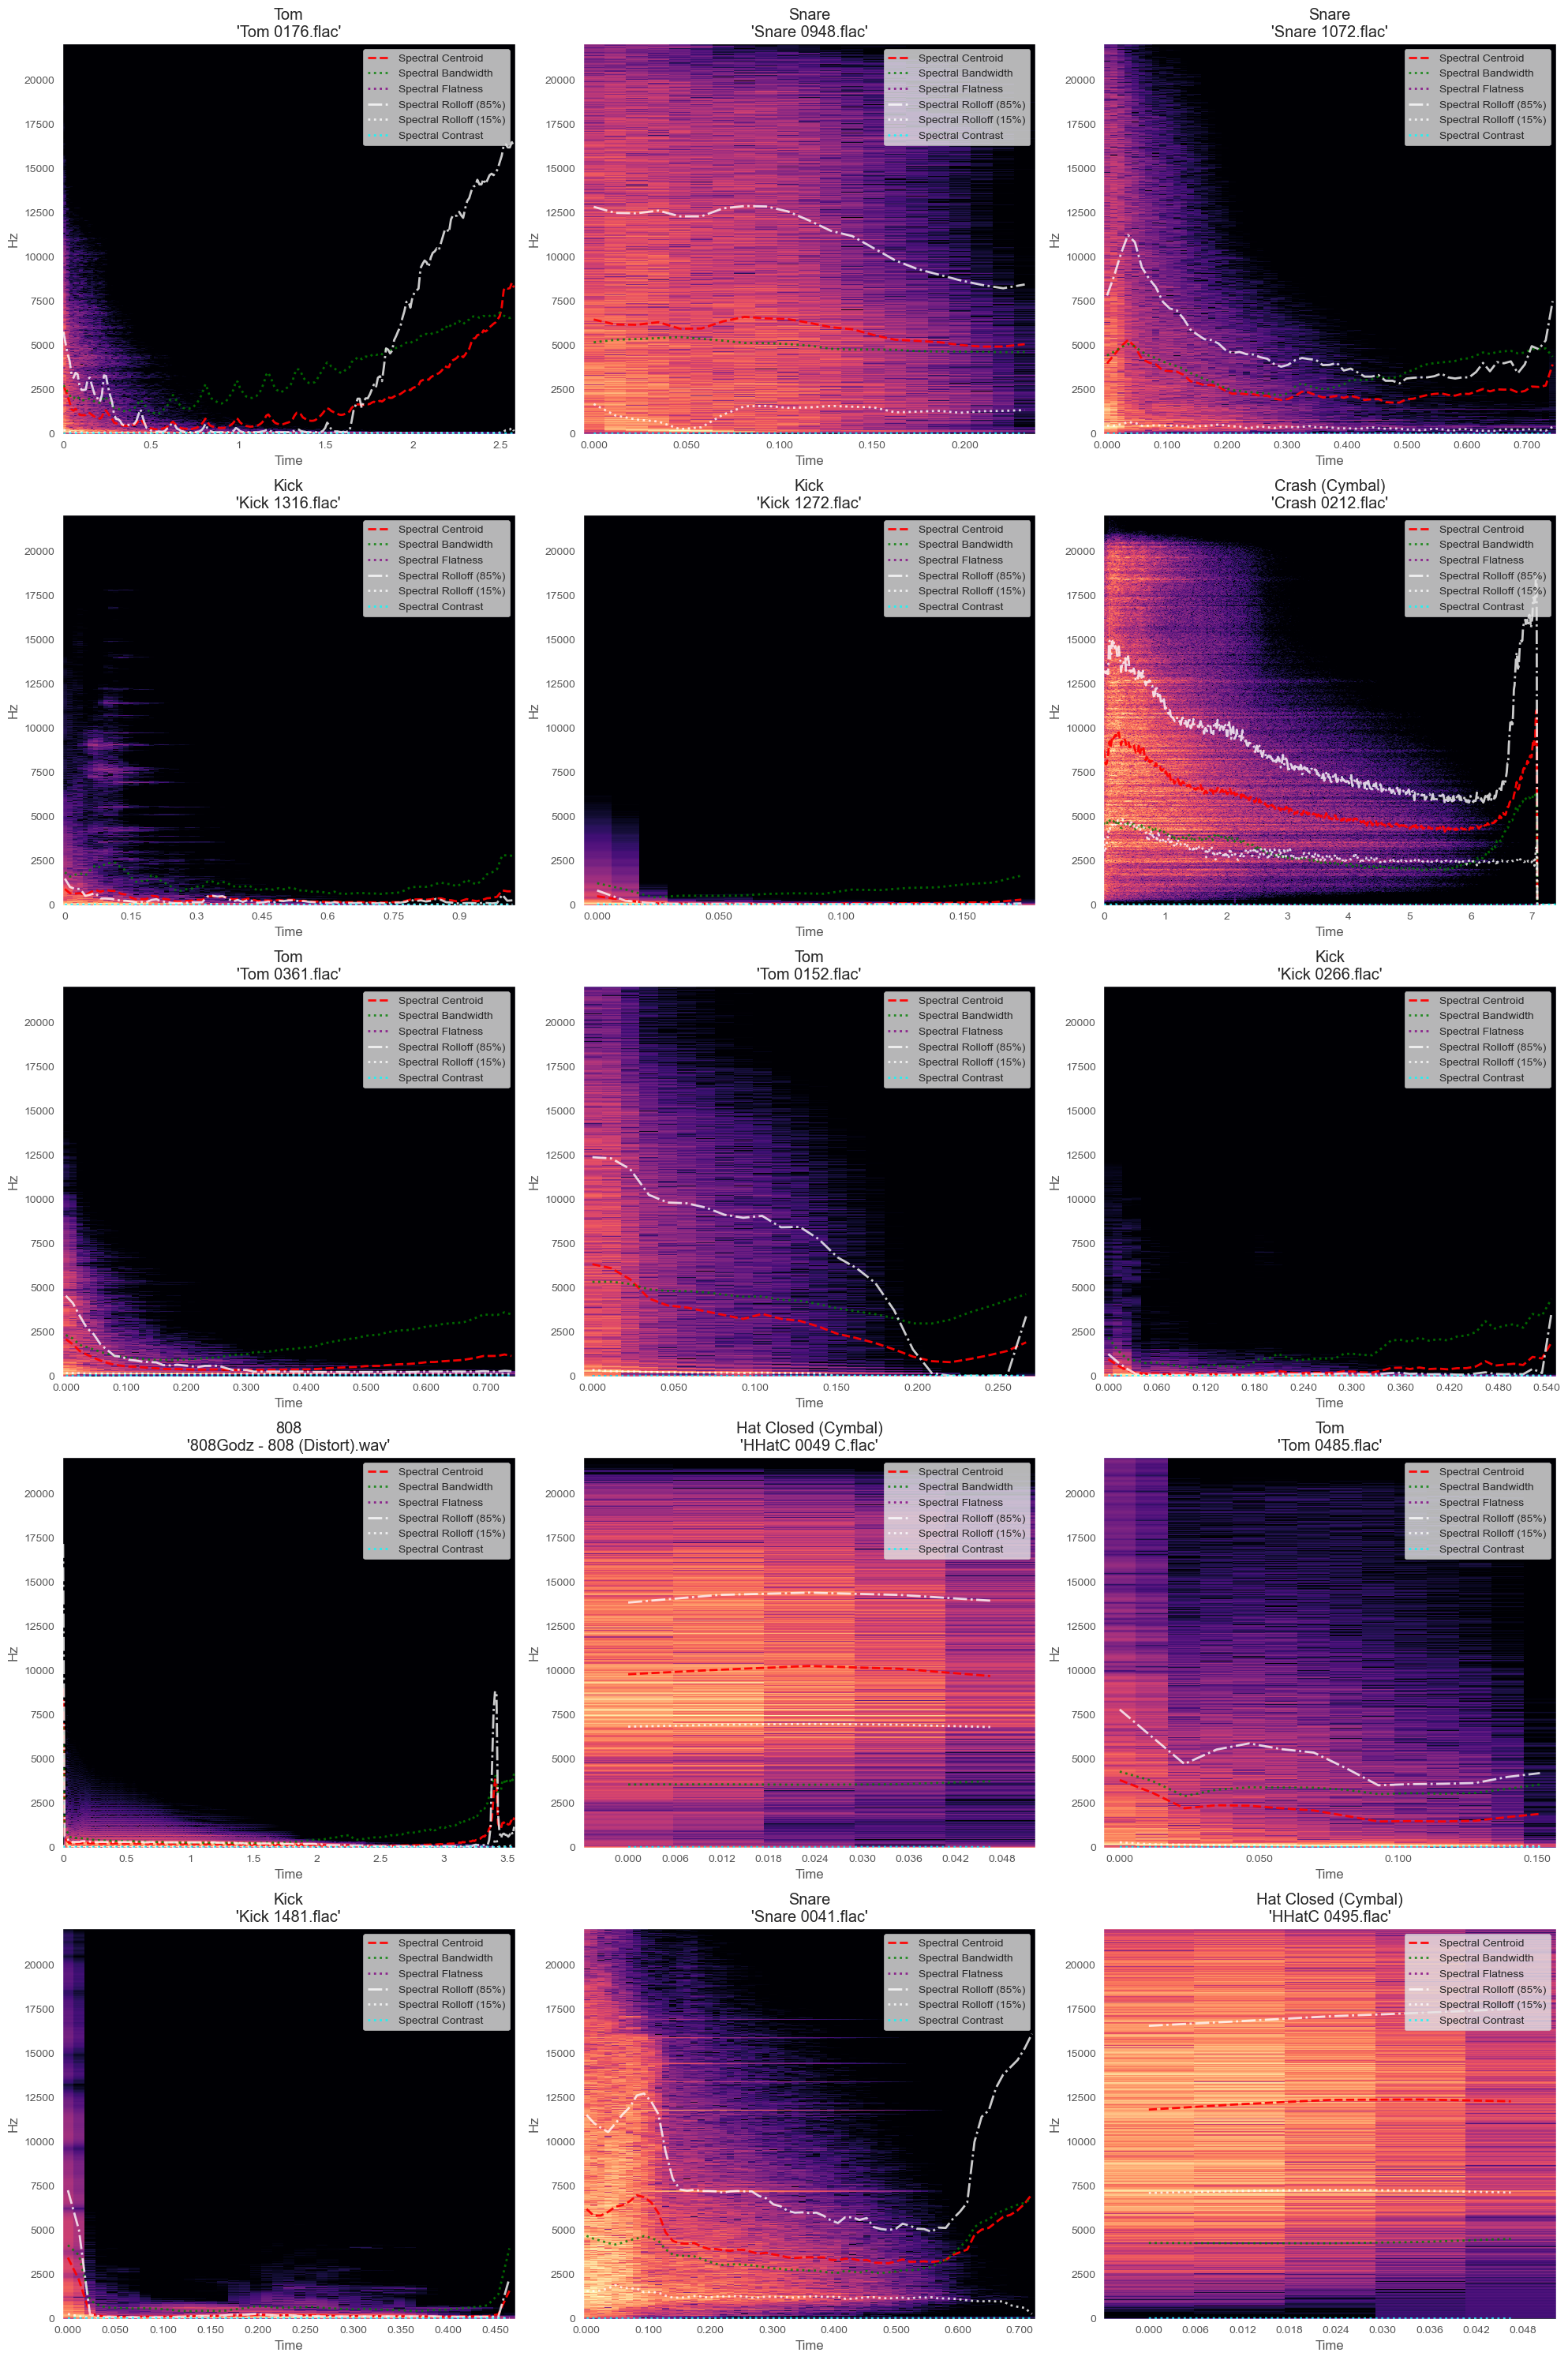

In [29]:
max_examples = 15
n_plots = len(y_sr_examples) if max_examples is None else min(max_examples, len(y_sr_examples))
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
for idx, (file_path, (y, sr)) in tqdm(enumerate(list(y_sr_examples.items())[:max_examples]), total=n_plots):
    ax = axs[idx // n_cols, idx % n_cols]
    # Calcul du spectrogramme
    D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Calcul du centroïde spectral
    spec_cent_stats, spec_cent = get_spectral_centroid(y, sr)

    # Calcul de la largeur de bande spectrale
    spec_bw_stats, spec_bw = get_spectral_bandwidth(y, sr)

    # Calcul de la flatness spectrale
    spec_flatness_stats, spec_flatness = get_spectral_flatness(y, sr)

    # Calcul du spectral rolloff 85
    spec_rolloff_85_stats, spec_rolloff_85 = get_spectral_rolloff(y, sr, roll_percent=0.85)

    # Calcul du spectral rolloff 15
    spec_rolloff_15_stats, spec_rolloff_15 = get_spectral_rolloff(y, sr, roll_percent=0.15)

    # Calcul du spectral contrast
    spec_contrast_stats, spec_contrast = get_spectral_contrast(y, sr)

    # Conversion des frames en temps
    frames = range(len(spec_cent[0]))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=N_FFT // 4)

    # Affichage du spectrogramme
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='hz', sr=sr, hop_length=HOP_LENGTH, ax=ax)
    #fig.colorbar(img, ax=ax, format="%+2.f dB")

    # Affichage

    ax.plot(t, spec_cent[0], color='red', linewidth=2, alpha=0.95, label='Spectral Centroid', linestyle='--')
    ax.plot(t, spec_bw[0], color='green', linewidth=2, alpha=0.8, label='Spectral Bandwidth', linestyle=':')
    ax.plot(t, spec_flatness[0], color='purple', linewidth=2, alpha=0.8, label='Spectral Flatness', linestyle=':')
    ax.plot(t, spec_rolloff_85[0], color='white', linewidth=2, alpha=0.8, label='Spectral Rolloff (85%)',
            linestyle='dashdot', )
    ax.plot(t, spec_rolloff_15[0], color='white', linewidth=2, alpha=0.8, label='Spectral Rolloff (15%)', linestyle=':')
    ax.plot(t, spec_contrast[0], color='cyan', linewidth=2, alpha=0.8, label='Spectral Contrast', linestyle=':')

    # Configuration des axes et du titre

    ax.legend(loc='upper right')
    title = f"{class_examples[file_path]}\n'{os.path.basename(file_path)}'"
    ax.set_title(title)

plt.tight_layout()
plt.show()

100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


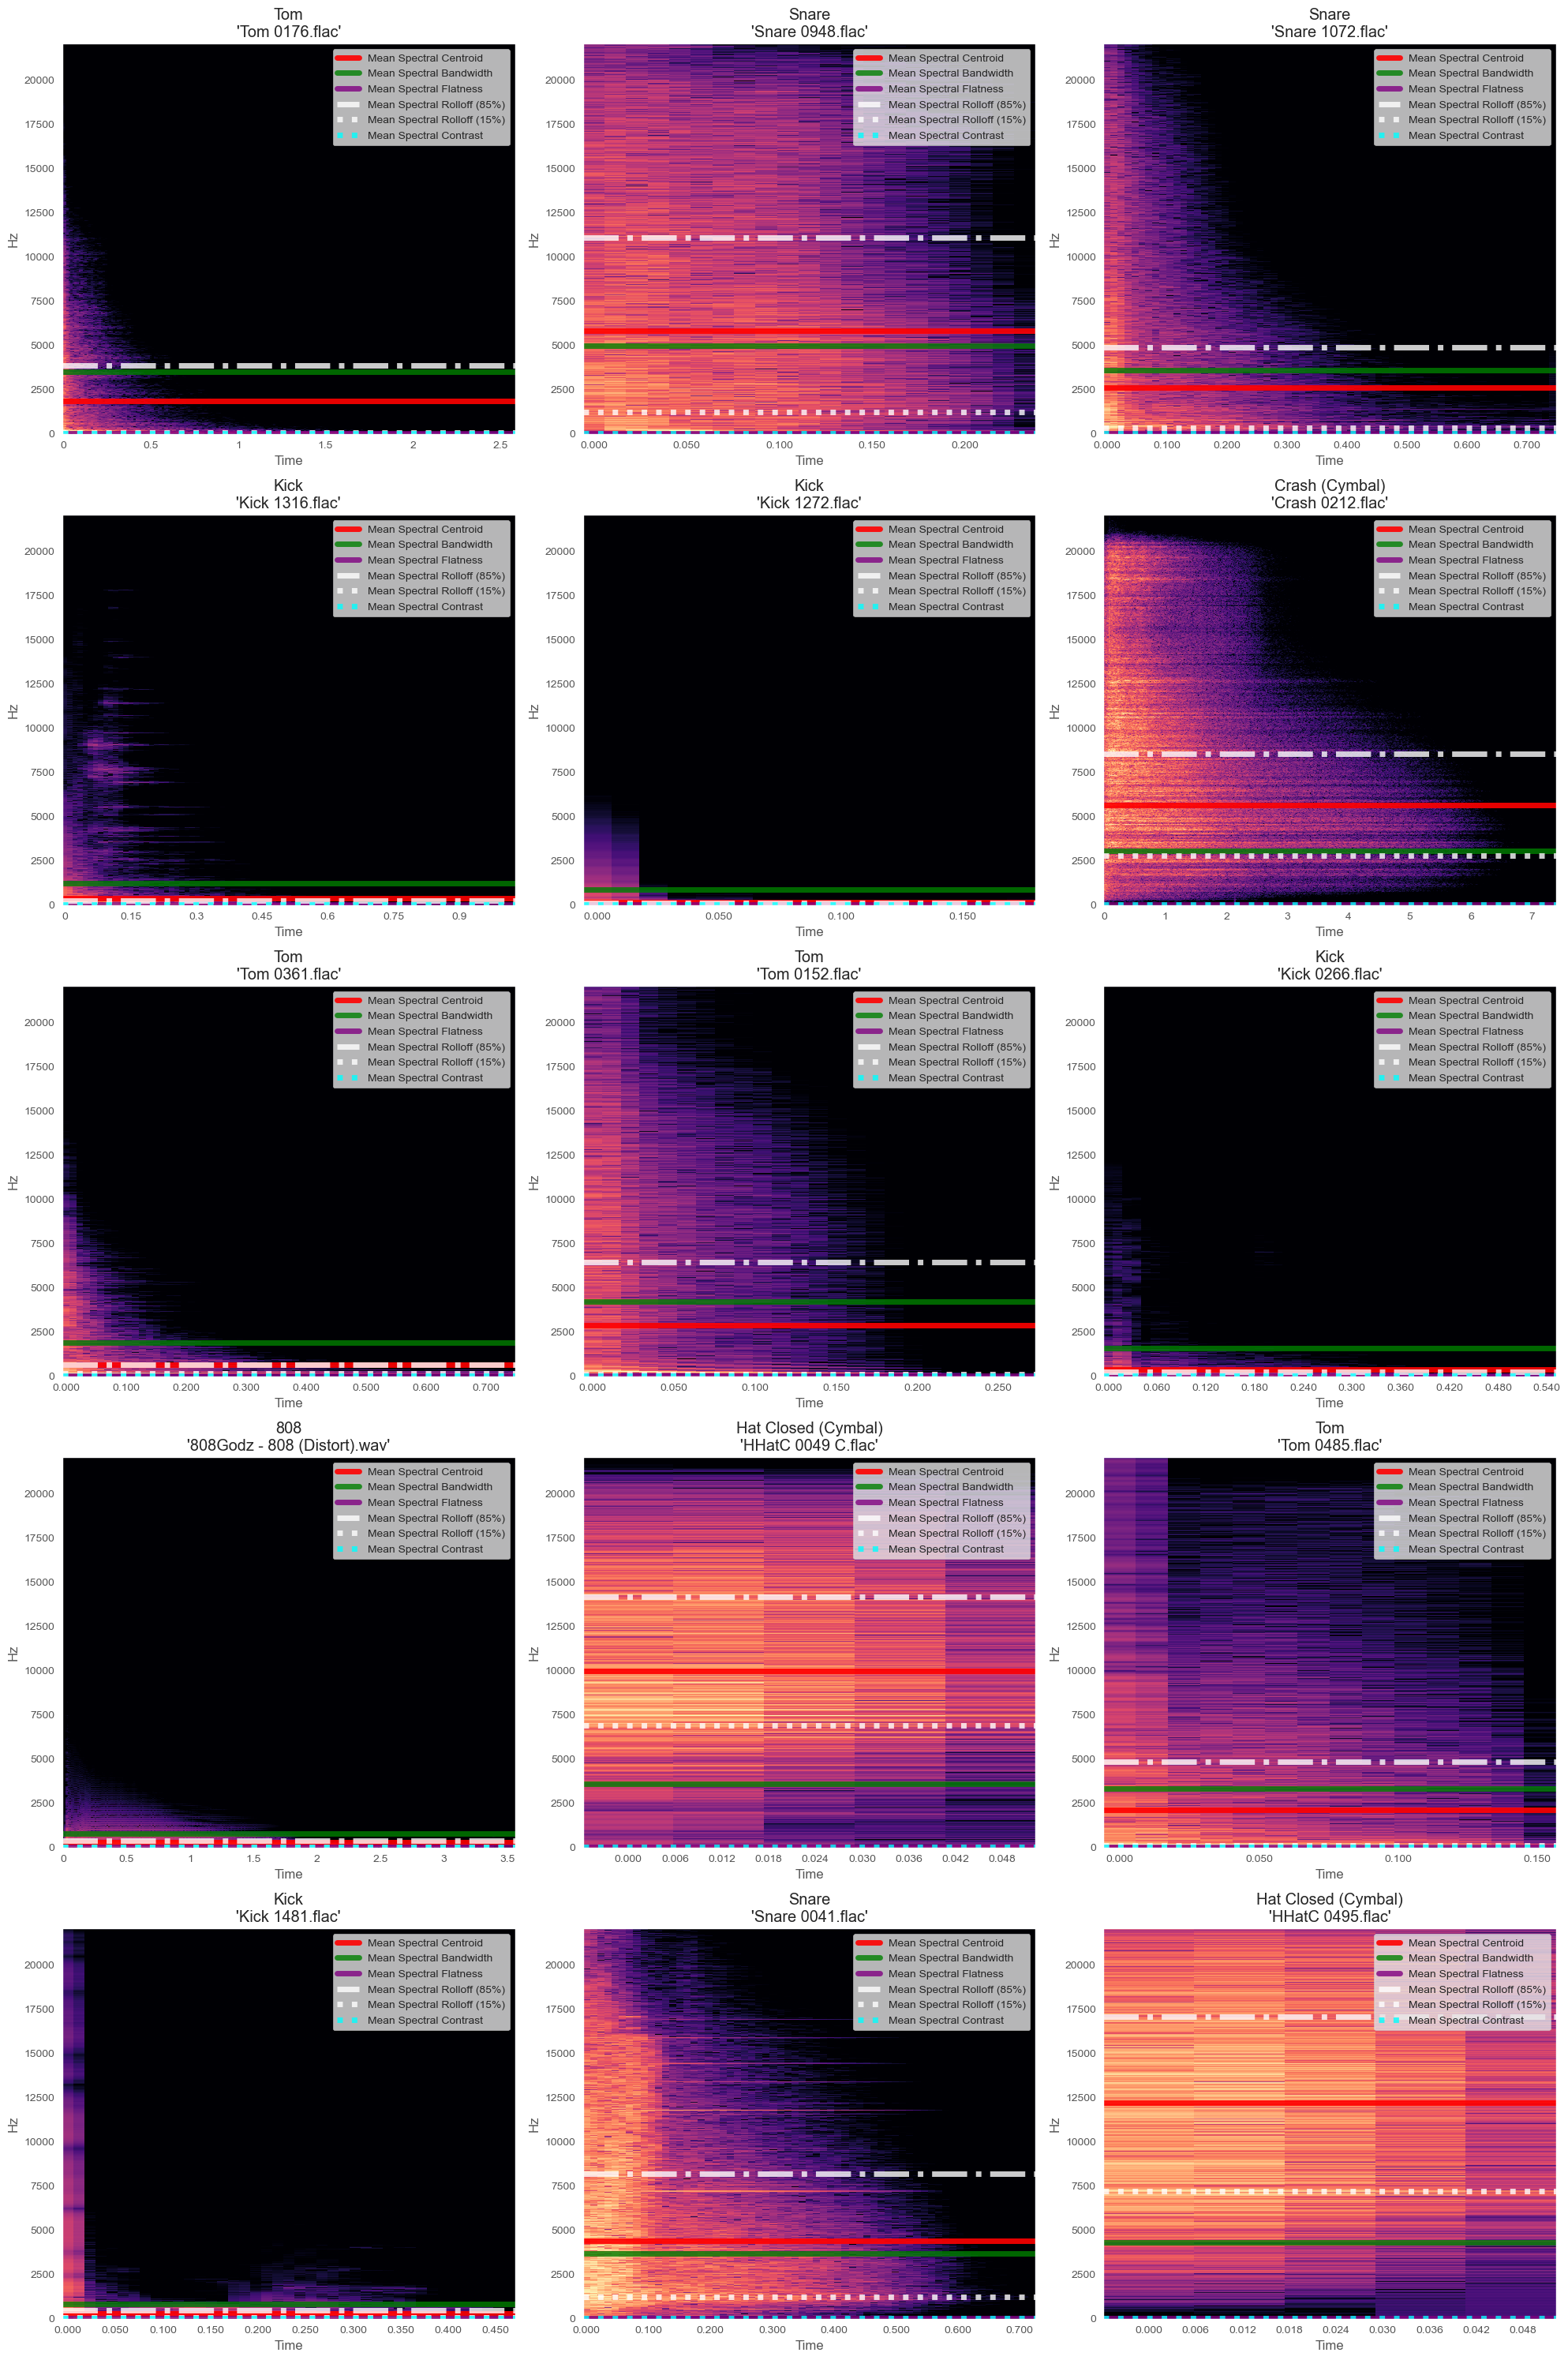

In [30]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
for idx, (file_path, (y, sr)) in tqdm(enumerate(list(y_sr_examples.items())[:max_examples]), total=n_plots):
    ax = axs[idx // n_cols, idx % n_cols]
    # Calcul du spectrogramme
    D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Calcul du centroïde spectral
    spec_cent_stats, spec_cent = get_spectral_centroid(y, sr)
    mean_spec_cent = spec_cent_stats["spec_cent_mean"]

    # Calcul de la largeur de bande spectrale
    spec_bw_stats, spec_bw = get_spectral_bandwidth(y, sr)
    mean_spec_bw = spec_bw_stats["spec_bw_mean"]

    # Calcul de la flatness spectrale
    spec_flatness_stats, spec_flatness = get_spectral_flatness(y, sr)
    mean_spec_flatness = spec_flatness_stats["spec_flatness_mean"]

    # Calcul du spectral rolloff 85
    spec_rolloff_85_stats, spec_rolloff_85 = get_spectral_rolloff(y, sr, roll_percent=0.85)
    mean_spec_rolloff_85 = spec_rolloff_85_stats["spec_rolloff_mean"]

    # Calcul du spectral rolloff 15
    spec_rolloff_15_stats, spec_rolloff_15 = get_spectral_rolloff(y, sr, roll_percent=0.15)
    mean_spec_rolloff_15 = spec_rolloff_15_stats["spec_rolloff_mean"]

    # Calcul du spectral contrast
    spec_contrast_stats, spec_contrast = get_spectral_contrast(y, sr)
    mean_spec_contrast = spec_contrast_stats["spec_contrast_mean"]

    # Conversion des frames en temps
    frames = range(len(spec_cent[0]))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=N_FFT // 4)

    # Affichage du spectrogramme
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='hz', sr=sr, hop_length=HOP_LENGTH, ax=ax)
    #fig.colorbar(img, ax=ax, format="%+2.f dB")

    # Affichage
    ax.axhline(mean_spec_cent, color='red', label='Mean Spectral Centroid', alpha=0.9, linewidth=5)
    ax.axhline(mean_spec_bw, color='green', label='Mean Spectral Bandwidth', alpha=0.8, linewidth=5)
    ax.axhline(mean_spec_flatness, color='purple', label='Mean Spectral Flatness', alpha=0.8, linewidth=5)
    ax.axhline(mean_spec_rolloff_85, color='white', label='Mean Spectral Rolloff (85%)', alpha=0.8, linewidth=5,
               linestyle='dashdot')
    ax.axhline(mean_spec_rolloff_15, color='white', label='Mean Spectral Rolloff (15%)', alpha=0.8, linewidth=5,
               linestyle=':')
    ax.axhline(mean_spec_contrast, color='cyan', label='Mean Spectral Contrast', alpha=0.8, linewidth=5, linestyle=':')

    # Configuration des axes et du titre

    ax.legend(loc='upper right')
    title = f"{class_examples[file_path]}\n'{os.path.basename(file_path)}'"
    ax.set_title(title)

plt.tight_layout()
plt.show()

## Extract features

In [31]:
def extract_features(y: np.ndarray, sr: int) -> dict:
    """
    Extract features from a sound.

    Args:
        y (np.ndarray): The sound.
        sr (int): The sampling rate of the sound.

    Returns:
        dict: A dictionary containing the extracted features.
    """


    features = {
        # time domain features
        "duration": librosa.get_duration(y=y, sr=sr),
        **get_log_rms_stats(y=y)[0],
        **get_zero_crossing_rate_stats(y=y)[0],
        "temp_cent" : get_temporal_centroid(y=y, sr=sr),
        "attack_time" : get_attack_time(y=y, sr=sr),
        #"decay_time" : get_decay_time(y=y, sr=sr),
        #"release_time" : get_release_time(y=y, sr=sr),
        # frequency domain features
        "pitch" : get_pitch(y=y, sr=sr),
        **flatten_dict(get_mfcc_stats(y=y, sr=sr),start=1),
        **get_spectral_centroid(y=y, sr=sr)[0],
        **get_spectral_bandwidth(y=y, sr=sr)[0],
        **get_spectral_flatness(y=y, sr=sr)[0],
        **get_spectral_rolloff(y=y, sr=sr,roll_percent=0.85)[0],
        **get_spectral_rolloff(y=y, sr=sr,roll_percent=0.15)[0],
        **get_spectral_contrast(y=y, sr=sr)[0],

    }

    return features


for file_path, (y, sr) in tqdm(list(y_sr_examples.items())[:2]):
    features = extract_features(y, sr)
    file_name = os.path.basename(file_path)
    print(f"> {len(features)} features extracted from {file_name}")
    print(features)

100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

> 96 features extracted from Tom 0176.flac
{'duration': 2.58750566893424, 'log_sum_rms': -470.30786, 'log_mean_rms': -2.1090038, 'log_max_rms': -0.50664246, 'log_rms_std': 0.8264498, 'log_rms_diff_mean': 0.058022678, 'log_crest_factor': 0.24022833, 'zcr_sum': 1.7138671875, 'zcr_mean': 0.0076855030829596415, 'zcr_std': 0.008645376205992508, 'zcr_loudest_frame': 0.060546875, 'temp_cent': 0.09532879818594105, 'attack_time': 0.0015419501133786847, 'pitch': 2004.5454545454545, 'mfcc_mean_1': -509.93317, 'mfcc_mean_2': 60.668594, 'mfcc_mean_3': 21.950005, 'mfcc_mean_4': 27.817469, 'mfcc_mean_5': 22.503761, 'mfcc_mean_6': 18.581118, 'mfcc_mean_7': 18.558378, 'mfcc_mean_8': 15.360952, 'mfcc_mean_9': 12.570641, 'mfcc_mean_10': 12.243543, 'mfcc_mean_11': 13.072695, 'mfcc_mean_12': 11.3664465, 'mfcc_std_1': 108.79631, 'mfcc_std_2': 59.801926, 'mfcc_std_3': 27.92402, 'mfcc_std_4': 16.038242, 'mfcc_std_5': 11.683852, 'mfcc_std_6': 9.268663, 'mfcc_std_7': 7.8008, 'mfcc_std_8': 6.441216, 'mfcc_std_9'

### • Extract features from dataset

In [32]:
# delete all variable memory
del y_sr_examples



In [33]:
dataset_csv_path = os.path.join(SOUNDS_DATASET_PATH, 'dataset.csv')
dataset = pd.read_csv(dataset_csv_path)
dataset

file_path           file_name   
0      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (1)  \
1      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (2)   
2      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (3)   
3      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (4)   
4      G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   KAMAL - Conga (5)   
...                                                  ...                 ...   
10300  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   Mid Seed Shaker 9   
10301  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 10   
10302  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 11   
10303  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 12   
10304  G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...  Mid Seed Shaker 13   

      file_extension   class  split  
0               .wav   Conga  train  
1               .wav   Conga   test  
2               .wav   Conga  train  
3               .wav   Conga  train  
4               .wav   Conga  train  
...              ...     ...    ...  
10300           .aif  Shaker  train  
10301           .aif  Shaker  train  
10302           .aif  Shaker  train  
10303           .aif  Shaker  train  
10304           .aif  Shaker   test  

[10305 rows x 5 columns]

In [34]:
dataset.describe()

file_path   
count                                               10305  \
unique                                              10305   
top     G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...   
freq                                                    1   

                            file_name file_extension  class  split  
count                           10305          10305  10305  10305  
unique                          10302              6     15      2  
top     [PS] Shaker Like Hi Hat (r&b)          .flac   Kick  train  
freq                                2           7640   1537   8759

In [ ]:
PARALLEL_MODE = True
N_WORKERS = 8
lock = threading.Lock()

def task_extract_features(sound):
    if not os.path.exists(sound.file_path):
        print(f"File {sound.file_path} does not exist")
        return None

    try:
        y, sr = load_audio_file(sound.file_path, sr=SAMPLE_RATE)
        y = pad_signal(y=y, target_length=N_FFT)
        features = extract_features(y, sr)
        features["file_path"] = sound.file_path
        return features
    except Exception as e:
        print(e)
        return None

if PARALLEL_MODE:
    print("> Start processing sounds (parallel mode)")
    sounds = dataset.itertuples()
    feature_dicts = []

    with ThreadPoolExecutor(max_workers=N_WORKERS) as executor:
        futures = [executor.submit(task_extract_features, sound) for sound in sounds]

        for future in tqdm(as_completed(futures), total=len(futures)):
            features = future.result()
            if features is not None:
                feature_dicts.append(features)

    print("> End processing sounds (parallel mode).")
    print(f"> {len(feature_dicts)}/{len(dataset)} sounds processed.")

    # Concatenate all the feature dictionaries into a new DataFrame
    feature_df = pd.DataFrame(feature_dicts)

    # Combine the original dataset and the feature DataFrame (merge on the file_path column)
    dataset = pd.merge(dataset, feature_df, on="file_path", how="left")
    print("> Dataset updated with the extracted features.")
    print(f"  > Dataset shape: {dataset.shape}")


else:
    print("> Start processing sounds (sequential mode)")
    feature_dicts = []

    # Iterate over the dataset and extract features
    for sound in tqdm(dataset.itertuples(), total=len(dataset)):
        y, sr = load_audio_file(sound.file_path, sr=SAMPLE_RATE)
        y = pad_signal(y=y, target_length=N_FFT)
        features = extract_features(y, sr)

        # Add an 'Index' key to the features dictionary to keep track of the original index
        features['Index'] = sound.Index
        feature_dicts.append(features)

    print("> End processing sounds (sequential mode).")

    # Convert the list of feature dictionaries into a DataFrame
    feature_df = pd.DataFrame(feature_dicts)

    # Set the 'Index' column as the index of the feature_df DataFrame
    feature_df.set_index('Index', inplace=True)

    # Combine the original dataset and the feature DataFrame
    dataset = pd.concat([dataset, feature_df], axis=1)
    print("> Dataset updated with the extracted features.")
    print(f" > Dataset shape: {dataset.shape}")



> Start processing sounds (parallel mode)


  2%|▏         | 167/10305 [00:16<15:00, 11.26it/s]G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Project\tools.py:42: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
H:\anaconda3\envs\drumclassifier_env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 174/10305 [00:16<08:04, 20.92it/s]

Erreur innatendue lors de la lecture du fichier G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Conga\808 Conga.wav: 
object of type 'NoneType' has no len()


  2%|▏         | 191/10305 [00:17<08:44, 19.27it/s]

Erreur innatendue lors de la lecture du fichier G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Conga\Afro 808 Conga.wav: 
object of type 'NoneType' has no len()


  6%|▌         | 603/10305 [01:47<09:06, 17.76it/s]  

Erreur innatendue lors de la lecture du fichier G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Open (Cymbal)\[OPEN-HATS] Nxsty UK Drill Kit V2 (1).wav: 
object of type 'NoneType' has no len()


  9%|▉         | 952/10305 [02:27<14:44, 10.57it/s]  

Erreur innatendue lors de la lecture du fichier G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_FDrk_004.wav: 
object of type 'NoneType' has no len()
Erreur innatendue lors de la lecture du fichier G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_GLite_004.wav: 
object of type 'NoneType' has no len()


 10%|▉         | 1021/10305 [02:40<21:43,  7.12it/s]

In [ ]:
dataset.describe().T

## Save the dataset

In [ ]:
# save the dataset (not the index)
dataset.to_csv(os.path.join(SOUNDS_DATASET_PATH, "dataset_handcrafted_features_extracted.csv"), index=False)